In [1683]:
!pip install seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [1762]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import yfinance as yf
from pandas.tseries.offsets import BDay
from scipy.optimize import minimize
import seaborn as sns

In [1763]:
crsp = pd.read_csv('./crsp_daily_1926_2023.csv')
crsp['RET'] = pd.to_numeric(crsp['RET'], errors='coerce')
crsp['PRC'] = pd.to_numeric(crsp['PRC'], errors='coerce')
crsp = crsp.dropna(subset=['RET', 'PRC'])
crsp.loc[crsp['PRC'] < 0, 'PRC'] = float('nan')
crsp['MV'] = (crsp['PRC'] * crsp['SHROUT'])
crsp['date'] = crsp['date'].str.replace('-','').astype(int)

In [1764]:
crsp = crsp[(crsp['EXCHCD'] == 1) | (crsp['EXCHCD'] == 2) | (crsp['EXCHCD'] == 3)]
crsp = crsp[(crsp['SHRCD'] == 10) | (crsp['SHRCD'] == 11)]

In [1765]:
crsp = crsp[crsp['date'] >= 20120725]

In [1766]:
permno_map = pd.read_csv('./comphist_202505.csv')

/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/1699232724.py:1: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  permno_map = pd.read_csv('./comphist_202505.csv')


In [1767]:
permno_map.columns

Index(['gvkey', 'conm', 'tic', 'cusip', 'cik', 'sic', 'naics', 'LINKPRIM',
       'LIID', 'LINKTYPE', 'LPERMNO', 'LPERMCO', 'LINKDT', 'LINKENDDT', 'EIN',
       'COSTAT', 'DLRSN', 'PRIUSA', 'PRICAN', 'PRIROW', 'IDBFLAG', 'FIC',
       'LOC', 'INCORP', 'STATE', 'COUNTY', 'CITY', 'CONML', 'WEBURL', 'PHONE',
       'FAX', 'ADD1', 'ADD2', 'ADD3', 'ADD4', 'ADDZIP', 'BUSDESC', 'ipodate',
       'dldte', 'STKO', 'FYRC', 'GSECTOR', 'GGROUP', 'GIND', 'GSUBIND',
       'SPCINDCD', 'SPCSECCD'],
      dtype='object')

In [1768]:
ff6 = pd.read_csv('./ff6_factors_19630701_20230131.csv')
ff6 = ff6.rename(columns={"ID" : "date"})
ff6['date'] = ff6['date'].astype(int)

In [1769]:
events = pd.read_csv('./events_with_mergers.csv').sort_values('Date', ignore_index=True).rename({'Date' : 'date'}, axis=1)
events['date'] = pd.to_numeric(events['date'], errors='coerce').astype('Int64')
events = events.dropna().reset_index()

In [1770]:
# events = events[events['Action'] == 'Add']

In [1771]:
normalize = {'DJIA' : 'DJIA',
 'DJT' : 'DJTA',
 'DJTA' : 'DJTA',
 'DJU' : 'DJUA',
 'DJUA' : 'DJUA',
 'S&P 400' : 'S&P 400',
 'S&P  400 INDEX' : 'S&P 400',
 'S&P 100' : 'S&P 100',
 'S&P 100 INDEX' : 'S&P 100',
 'S&P 400 INDEX' : 'S&P 400',
 'S&P 500' : 'S&P 500',
 'S&P 500 INDEX' : 'S&P 500',
 'S&P 600 INDEX' : 'S&P 600',
 'S&P 600' : 'S&P 600',
 'S&P MIDCAP 400' : 'S&P MIDCAP 400',
 'S&P MIDCAP 400 INDEX' : 'S&P MIDCAP 400',
 'S&P MIDCAP 500 INDEX' : 'S&P MIDCAP 500',
 'S&P MIDCAP 500' : 'S&P MIDCAP 500',
 'S&P MidCap 400' : 'S&P MIDCAP 400',
 'S&P MidCap 400 INDEX' : 'S&P MIDCAP 400',
 'S&P MidCap 401' : 'S&P MIDCAP 400',
 'S&P MidCap 402' : 'S&P MIDCAP 400',
 'S&P MidCap 403' : 'S&P MIDCAP 400',
 'S&P SMALLCAP 600' : 'S&P SMALLCAP 600',
 'S&P SMALLCAP 600 INDEX' : 'S&P SMALLCAP 600',
 'S&P SmallCap 600' : 'S&P SMALLCAP 600',
 'S&P SmallCap 600 INDEX' : 'S&P SMALLCAP 600',
 'S&P SmallCap 601' : 'S&P SMALLCAP 600',
 'S&P SmallCap 602' : 'S&P SMALLCAP 600',
 'S&P SmallCap 603' : 'S&P SMALLCAP 600'}

In [1772]:
events['Index'] = events['Index'].apply(lambda x : normalize[x])

In [1773]:
def get_permno(tckr):
    permno = permno_map[permno_map['tic'] == tckr]['LPERMNO']
    if permno.empty:
        return []
    return list(permno)

In [1774]:
def get_return(tckr, start_date, end_date):
    permnos = get_permno(tckr)
    data = pd.DataFrame()
    for permno in permnos:
        new_data = crsp[(crsp['date'] > start_date) & (crsp['date'] <= end_date)]
        new_data = new_data[new_data['PERMNO'] == permno]
        data = pd.concat([data, new_data], ignore_index=False)
    return data

# def get_return(tckr, start_date, end_date):
#     data = yf.download(tckr, start=pd.to_datetime(start_date, format='%Y%m%d') + BDay(1), end=pd.to_datetime(end_date, format='%Y%m%d'))
#     data['RET'] = data['Open'].pct_change() * 100
#     data.columns = data.columns.get_level_values(0)
#     data = data.reset_index()
#     data = data[['Date', 'Open', 'Close', 'Volume', 'RET']]
#     data['Ticker'] = tckr
#     return data

In [1621]:
portfolio = pd.DataFrame()
no_data = []
for row in events.iterrows():
    tckr = row[1]['Ticker']
    start_date = row[1]['Announced Date']
    end_date = row[1]['date']
    returns_within_range = get_return(tckr, start_date, end_date)
    if returns_within_range.empty:
        no_data.append({'Ticker': tckr,
                        'Action': row[1]['Action'],
                        'Company': row[1]['Company']})
    returns_within_range['Action'] = row[1]['Action']
    returns_within_range['Merger'] = row[1]['Merger']
    portfolio = pd.concat([portfolio, returns_within_range], ignore_index=True)

In [1622]:
portfolio = portfolio.rename({'Date' : 'date'}, axis=1)
portfolio['date'] = portfolio['date'].astype(str).str.replace('-', '').str.replace('.', '').astype(int)

In [1623]:
portfolio = pd.merge(ff6, portfolio, how='left', on='date')
portfolio = portfolio[portfolio['date'] >= 20120725]

In [1624]:
def calc_weight(group):
    total_abs = group['LS'].abs().sum()
    group = group.copy()
    group['weight'] = group['LS'] / total_abs
    return group

############
def calc_weight_mean_variance(group, window=20):
    date = group['date'].iloc[0]

    prev_date = pd.to_datetime(str(date), format="%Y%m%d") - pd.tseries.offsets.BDay(window)
    prev_date = int(str(prev_date).split(' ')[0].replace('-', ''))
    
    permnos = group['PERMNO']

    crsp_window = crsp[(crsp['PERMNO'].isin(permnos)) & (crsp['date'] >= prev_date) & (crsp['date'] < date)]

    R = crsp_window.pivot(index='date', columns='PERMNO', values='RET')
    R = R.dropna(axis=1, how='any')

    if R.empty or R.shape[1] == 0:
        group['weight_mv'] = 1 / len(group)
        return group
    
    mu = R.mean().values  # expected returns vector
    cov = R.cov().values  # covariance matrix
    n = len(mu)

    def objective(w):
        # Minimize -return + λ * variance (λ = 1 for now)
        return -np.dot(w, mu) + 1.0 * np.dot(w.T, np.dot(cov, w))

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1) for _ in range(n)]

    w0 = np.ones(n) / n
    result = minimize(objective, w0, bounds=bounds, constraints=constraints)

    optimal_weights = result.x
    valid_permnos = R.columns.tolist()

    weight_map = dict(zip(valid_permnos, optimal_weights))
    group['weight_mv'] = group['PERMNO'].map(weight_map).fillna(0)

    return group
##################

def calc_weight_risk_parity(group, window=20):
    date = group['date'].iloc[0]

    prev_date = pd.to_datetime(str(date), format="%Y%m%d") - BDay(window)
    prev_date = int(str(prev_date).split(' ')[0].replace('-', ''))

    permnos = group['PERMNO']
    crsp_window = crsp[crsp['PERMNO'].isin(permnos) & (crsp['date'] >= prev_date) & (crsp['date'] < date)]
    vol_df = crsp_window.groupby('PERMNO')['RET'].std().reset_index().rename(columns={'RET': 'vol'})
    group = group.merge(vol_df, on='PERMNO', how='left')
        
    group['weight_rp'] = 1 / group['vol']
    group.loc[group['vol'] == 0, 'weight_rp'] = 0

    total = group['weight_rp'].sum()
    group['weight_rp'] = group['weight_rp'] / total if total > 0 else 1 / len(group)
    return group

In [1625]:
portfolio = portfolio.groupby(['date']).apply(calc_weight_mean_variance).reset_index(drop=True)

/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/499403774.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight_mean_variance).reset_index(drop=True)


In [1626]:
portfolio = portfolio.groupby(['date']).apply(calc_weight_risk_parity).reset_index(drop=True)

/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/1623933495.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight_risk_parity).reset_index(drop=True)


In [1627]:
portfolio['LS'] = portfolio['Action'].apply(lambda x : 1 if x == 'Add' else -1 )

In [1628]:
portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)
portfolio['portfolio_ret'] = portfolio['weight'] * portfolio['RET']
portfolio['portfolio_ret_rp'] = portfolio['weight_rp'] * portfolio['RET']
portfolio['portfolio_ret_mv'] = portfolio['weight_mv'] * portfolio['RET']

/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/1419178137.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)


In [ ]:
portfolio

,date,Mkt-RF,SMB,HML,RMW,CMA,MOM,RF,PERMNO,SHRCD,...,SHROUT,MV,Action,Merger,vol,weight_rp,LS,weight,portfolio_ret,portfolio_ret_rp
0,20120725,-0.01,0.23,0.00,-0.52,0.06,-0.20,0.000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.000000,-1,-1.000000,NaN,NaN
1,20120726,1.53,-0.80,0.34,0.07,0.27,-0.64,0.000,38755.0,11.0,...,25632.0,856108.80,Del,True,NaN,0.333333,-1,-0.333333,0.004819,-0.004819
2,20120726,1.53,-0.80,0.34,0.07,0.27,-0.64,0.000,88167.0,11.0,...,26173.0,728656.32,Add,True,NaN,0.333333,1,0.333333,0.015539,0.015539
3,20120726,1.53,-0.80,0.34,0.07,0.27,-0.64,0.000,92931.0,11.0,...,73961.0,3913276.51,Add,True,NaN,0.333333,1,0.333333,0.023107,0.023107
4,20120727,1.96,0.55,0.07,-0.17,-0.35,-0.96,0.000,38755.0,11.0,...,25632.0,850854.24,Del,True,0.002681,0.897060,-1,-0.333333,0.002046,-0.005506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8260,20230130,-1.38,0.05,0.72,0.40,0.81,1.36,0.017,92601.0,11.0,...,77872.0,2607933.28,Add,True,0.026531,0.049597,1,0.250000,-0.008160,-0.001619
8261,20230131,1.57,0.94,-0.06,-0.06,-0.53,-0.70,0.017,20920.0,11.0,...,164875.0,4482951.25,Add,True,0.031374,0.076617,1,0.250000,0.002226,0.000682
8262,20230131,1.57,0.94,-0.06,-0.06,-0.53,-0.70,0.017,26614.0,11.0,...,122465.0,4419761.85,Del,True,0.003120,0.770413,-1,-0.250000,0.000139,-0.000427
8263,20230131,1.57,0.94,-0.06,-0.06,-0.53,-0.70,0.017,92601.0,11.0,...,77872.0,2610269.44,Add,True,0.027326,0.087967,1,0.250000,0.000224,0.000079


In [1629]:
eqports = portfolio.groupby(['date'])['portfolio_ret_mv'].sum()
eqports = eqports.dropna(axis=0)
eqports = eqports * 100
eqports = eqports.reset_index()

In [1630]:
eqports[eqports['portfolio_ret_mv'] == 0].count() / len(eqports)

date                1.0
portfolio_ret_mv    1.0
dtype: float64

In [1631]:
stratmean = eqports['portfolio_ret_mv'].mean()
stratvol = eqports['portfolio_ret_mv'].std()
stratsharpe = stratmean/stratvol

/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/2112752488.py:3: RuntimeWarning: invalid value encountered in scalar divide
  stratsharpe = stratmean/stratvol


In [1632]:
print("{} has mean {}, vol {}, and Sharpe {}".format('Equal Portfolio', stratmean, stratvol, stratsharpe))

Equal Portfolio has mean 0.0, vol 0.0, and Sharpe nan


In [1279]:
eqports_ff = pd.merge(eqports, ff6, how='left', on='date')
eqports_ff = eqports_ff.dropna()
eqports_ff['Mkt-RF'] = pd.to_numeric(eqports_ff['Mkt-RF'], errors='coerce')
eqports_ff['SMB'] = pd.to_numeric(eqports_ff['SMB'], errors='coerce')
eqports_ff['HML'] = pd.to_numeric(eqports_ff['HML'], errors='coerce')
eqports_ff['RMW'] = pd.to_numeric(eqports_ff['RMW'], errors='coerce')
eqports_ff['CMA'] = pd.to_numeric(eqports_ff['CMA'], errors='coerce')
eqports_ff['MOM'] = pd.to_numeric(eqports_ff['MOM'], errors='coerce')
eqports_ff['RF'] = pd.to_numeric(eqports_ff['RF'], errors='coerce')

In [1280]:
capm_eq=sm.OLS(eqports_ff['portfolio_ret'],
              sm.add_constant(eqports_ff[['Mkt-RF']])).fit()
print(capm_eq.summary())

KeyError: 'portfolio_ret'

In [ ]:
ff3_eq=sm.OLS(eqports_ff['portfolio_ret'],
              sm.add_constant(eqports_ff[['Mkt-RF', 'SMB', 'HML']])).fit()
print(ff3_eq.summary())

                            OLS Regression Results                            
Dep. Variable:          portfolio_ret   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     9.791
Date:                Sun, 01 Jun 2025   Prob (F-statistic):           2.02e-06
Time:                        13:12:16   Log-Likelihood:                -5436.0
No. Observations:                2647   AIC:                         1.088e+04
Df Residuals:                    2643   BIC:                         1.090e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4527      0.037     12.321      0.0

In [ ]:
ff5_eq=sm.OLS(eqports_ff['portfolio_ret'],
              sm.add_constant(eqports_ff[['Mkt-RF', 'SMB', 'HML', 'CMA', 'RMW']])).fit()
print(ff5_eq.summary())

                            OLS Regression Results                            
Dep. Variable:          portfolio_ret   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     6.186
Date:                Sun, 01 Jun 2025   Prob (F-statistic):           1.04e-05
Time:                        13:12:16   Log-Likelihood:                -5435.2
No. Observations:                2647   AIC:                         1.088e+04
Df Residuals:                    2641   BIC:                         1.092e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4545      0.037     12.361      0.0

In [ ]:
ff6_eq=sm.OLS(eqports_ff['portfolio_ret'],
              sm.add_constant(eqports_ff[['Mkt-RF', 'SMB', 'HML', 'CMA', 'RMW', 'MOM']])).fit()
print(ff6_eq.summary())

                            OLS Regression Results                            
Dep. Variable:          portfolio_ret   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     6.025
Date:                Sun, 01 Jun 2025   Prob (F-statistic):           2.84e-06
Time:                        13:12:17   Log-Likelihood:                -5432.6
No. Observations:                2647   AIC:                         1.088e+04
Df Residuals:                    2640   BIC:                         1.092e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4547      0.037     12.375      0.0

In [ ]:
eqports_ff['cum_ret'] = (1 + (eqports_ff['portfolio_ret_mv'] / 100)).cumprod() - 1
eqports_ff['mkt_cum_ret'] = (1 + (eqports_ff['Mkt-RF'] / 100)).cumprod() - 1

<Axes: title={'center': 'Equal Portfolio Cumulative Returns'}>

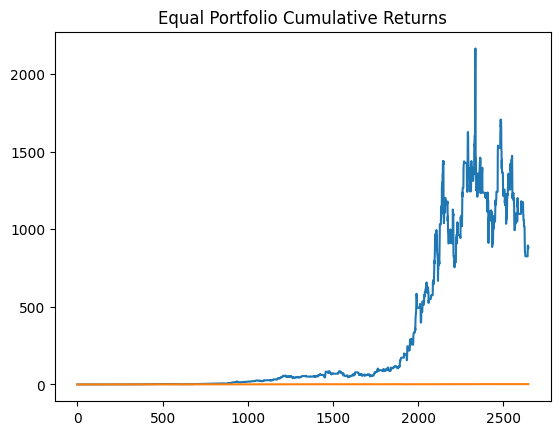

In [ ]:
eqports_ff['cum_ret'].plot(title='Equal Portfolio Cumulative Returns')
eqports_ff['mkt_cum_ret'].plot()

# S&P 500

In [1820]:
events = events[events['Action'] == 'Add']

In [1821]:
s_and_p = events[events['Index'].astype(str).str.contains('S&P 500', na=False)].reset_index()

In [1822]:
s_and_p = s_and_p.drop(['index', 'level_0'], axis=1)

In [1823]:
s_and_p

,date,Index,Action,Company,Ticker,Sector,URL,Announced Date,Merger
0,20120730,S&P 500,Add,Ensco,ESV,Energy,https://press.spglobal.com/2012-07-26-Ensco-pl...,20120726,True
1,20120904,S&P 500,Add,LyondellBasell,LYB,Materials,https://press.spglobal.com/2012-08-29-Lyondell...,20120829,False
2,20120928,S&P 500,Add,ADT,LXK,Industrials,https://press.spglobal.com/2012-09-24-ADT-Pent...,20120924,False
3,20120928,S&P 500,Add,Pentair,DV,Industrials,https://press.spglobal.com/2012-09-24-ADT-Pent...,20120924,False
4,20121001,S&P 500,Add,Kraft Foods Group,KRFTV,Consumer Staples,https://press.spglobal.com/2012-09-25-Kraft-Fo...,20120925,True
...,...,...,...,...,...,...,...,...,...
228,20250324,S&P 500,Add,Expand Energy,EXE,Energy,https://press.spglobal.com/2025-03-07-DoorDash...,20250307,False
229,20250324,S&P 500,Add,Williams-Sonoma,WSM,Consumer Discretionary,https://press.spglobal.com/2025-03-07-DoorDash...,20250307,False
230,20250324,S&P 500,Add,TKO Group Holdings,TKO,Communication Services,https://press.spglobal.com/2025-03-07-DoorDash...,20250307,False
231,20250324,S&P 500,Add,DoorDash,DASH,Consumer Discretionary,https://press.spglobal.com/2025-03-07-DoorDash...,20250307,False


In [1824]:
portfolio = pd.DataFrame()
no_data = []
for row in s_and_p.iterrows():
    tckr = row[1]['Ticker']
    start_date = row[1]['Announced Date']
    end_date = row[1]['date']
    returns_within_range = get_return(tckr, start_date, end_date)
    if returns_within_range.empty:
        no_data.append({'Ticker': tckr,
                        'Action': row[1]['Action'],
                        'Company': row[1]['Company']})
    returns_within_range['Action'] = row[1]['Action']
    returns_within_range['Merger'] = row[1]['Merger']
    portfolio = pd.concat([portfolio, returns_within_range], ignore_index=True)

In [1825]:
portfolio['LS'] = portfolio['Action'].apply(lambda x : 1 if x == 'Add' else -1 )

In [1826]:
portfolio = portfolio.rename({'Date' : 'date'}, axis=1)

In [1827]:
portfolio['date'] = portfolio['date'].astype(int).astype(str).str.replace('-', '').str.replace('.', '').astype(int)

In [1828]:
portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)
portfolio = portfolio.groupby(['date']).apply(calc_weight_mean_variance).reset_index(drop=True)
portfolio = portfolio.groupby(['date']).apply(calc_weight_risk_parity).reset_index(drop=True)

/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/1971382484.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)
/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/1971382484.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight_mean_variance)

In [1829]:
portfolio['portfolio_ret'] = portfolio['weight'] * portfolio['RET']
portfolio['portfolio_ret_mv'] = portfolio['weight_mv'] * portfolio['RET']
portfolio['portfolio_ret_rp'] = portfolio['weight_rp'] * portfolio['RET']

In [1830]:
portfolio

,Action,Merger,PERMNO,date,SHRCD,EXCHCD,TICKER,PRC,VOL,RET,SHROUT,MV,LS,weight,weight_mv,vol,weight_rp,portfolio_ret,portfolio_ret_mv,portfolio_ret_rp
0,Add,False,82643.0,20120925,11.0,1.0,LXK,22.35000,3155700.0,-0.018014,70323.0,1.571719e+06,1,1.000000,1.000000e+00,0.036737,1.000000,-0.018014,-1.801400e-02,-0.018014
1,Add,False,82643.0,20120926,11.0,1.0,LXK,22.19000,2335900.0,-0.007159,70323.0,1.560467e+06,1,1.000000,1.000000e+00,0.020917,1.000000,-0.007159,-7.159000e-03,-0.007159
2,Add,False,82643.0,20120927,11.0,1.0,LXK,22.87000,1843500.0,0.030644,70323.0,1.608287e+06,1,1.000000,1.000000e+00,0.020774,1.000000,0.030644,3.064400e-02,0.030644
3,Add,False,82643.0,20120928,11.0,1.0,LXK,22.25000,21942200.0,-0.027110,70323.0,1.564687e+06,1,1.000000,1.000000e+00,0.021311,1.000000,-0.027110,-2.711000e-02,-0.027110
4,Add,True,79411.0,20121002,11.0,3.0,PETM,68.55000,2013225.0,0.014654,108186.0,7.416150e+06,1,1.000000,1.000000e+00,0.010041,1.000000,0.014654,1.465400e-02,0.014654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855,Add,False,79094.0,20231215,11.0,1.0,JBL,132.91000,27702504.0,-0.025729,127945.0,1.700517e+07,1,0.333333,0.000000e+00,0.042727,0.150746,-0.008576,-0.000000e+00,-0.003879
856,Add,False,18576.0,20231215,11.0,1.0,UBER,61.86000,364261230.0,-0.010240,2057858.0,1.272991e+08,1,0.333333,5.551115e-17,0.010814,0.595604,-0.003413,-5.684342e-19,-0.006099
857,Add,False,90720.0,20231218,11.0,1.0,BLDR,160.12000,2716535.0,-0.014707,123347.0,1.975032e+07,1,0.333333,1.000000e+00,0.027554,0.247298,-0.004902,-1.470700e-02,-0.003637
858,Add,False,79094.0,20231218,11.0,1.0,JBL,130.21001,2267864.0,-0.020314,127945.0,1.665972e+07,1,0.333333,0.000000e+00,0.043231,0.157621,-0.006771,-0.000000e+00,-0.003202


In [1831]:
dates = pd.DataFrame(crsp['date'].unique()).rename({0: 'date'}, axis=1)
dates[dates['date'] <= 20230131]

,date
0,20120725
1,20120726
2,20120727
3,20120730
4,20120731
...,...
2642,20230125
2643,20230126
2644,20230127
2645,20230130


In [1832]:
dates2 = pd.DataFrame(ff6['date'].unique()).rename({0: 'date'}, axis=1)
dates2 = dates2[dates2['date'] >= 20120725]

In [1833]:
# Experiment
portfolio = dates.merge(portfolio, on='date', how='outer')
portfolio['portfolio_ret'] = portfolio['portfolio_ret'].fillna(0)
portfolio['portfolio_ret_mv'] = portfolio['portfolio_ret_mv'].fillna(0)
portfolio['portfolio_ret_rp'] = portfolio['portfolio_ret_rp'].fillna(0)
portfolio

,date,Action,Merger,PERMNO,SHRCD,EXCHCD,TICKER,PRC,VOL,RET,SHROUT,MV,LS,weight,weight_mv,vol,weight_rp,portfolio_ret,portfolio_ret_mv,portfolio_ret_rp
0,20120725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,20120726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,20120727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,20120730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,20120731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3261,20231222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3262,20231226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3263,20231227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3264,20231228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [1834]:
eqports = portfolio.groupby(['date'])['portfolio_ret'].sum()
eqports = eqports.dropna(axis=0)
eqports = eqports * 100
eqports = eqports.reset_index()

mvports = portfolio.groupby(['date'])['portfolio_ret_mv'].sum()
mvports = mvports.dropna(axis=0)
mvports = mvports * 100
mvports = mvports.reset_index()

rpports = portfolio.groupby(['date'])['portfolio_ret_rp'].sum()
rpports = rpports.dropna(axis=0)
rpports = rpports * 100
rpports = rpports.reset_index()

In [1835]:
print(eqports[eqports['portfolio_ret'] == 0].count() / len(eqports))
print(mvports[mvports['portfolio_ret_mv'] == 0].count() / len(eqports))
print(rpports[rpports['portfolio_ret_rp'] == 0].count() / len(eqports))

date             0.836635
portfolio_ret    0.836635
dtype: float64
date                0.836635
portfolio_ret_mv    0.836635
dtype: float64
date                0.836635
portfolio_ret_rp    0.836635
dtype: float64


In [1836]:
stratmean = eqports['portfolio_ret'].mean()
stratvol = eqports['portfolio_ret'].std()
stratsharpe = stratmean/stratvol
print("{} has mean {}, vol {}, and Sharpe {}".format('Equal Portfolio', stratmean, stratvol, stratsharpe))

stratmean = mvports['portfolio_ret_mv'].mean()
stratvol = mvports['portfolio_ret_mv'].std()
stratsharpe = stratmean/stratvol
print("{} has mean {}, vol {}, and Sharpe {}".format('Mean Variance Portfolio', stratmean, stratvol, stratsharpe))

stratmean = rpports['portfolio_ret_rp'].mean()
stratvol = rpports['portfolio_ret_rp'].std()
stratsharpe = stratmean/stratvol
print("{} has mean {}, vol {}, and Sharpe {}".format('Risk Parity Portfolio', stratmean, stratvol, stratsharpe))

Equal Portfolio has mean 0.07168400880546867, vol 1.0981615128793818, and Sharpe 0.06527638053669632
Mean Variance Portfolio has mean 0.07203226605790461, vol 1.2496528017088178, and Sharpe 0.05764182336038077
Risk Parity Portfolio has mean 0.07076592051659382, vol 1.0844610917855517, and Sharpe 0.06525445776950707


In [1837]:
# ports_ff = pd.merge([eqports, mvports, rpports, ff6], how='left', on='date')
ports_ff = eqports.merge(mvports, how='left', on='date') \
                  .merge(rpports, how='left', on='date') \
                  .merge(ff6, how='left', on='date')
ports_ff = ports_ff.dropna()
ports_ff['Mkt-RF'] = pd.to_numeric(ports_ff['Mkt-RF'], errors='coerce')
ports_ff['SMB'] = pd.to_numeric(ports_ff['SMB'], errors='coerce')
ports_ff['HML'] = pd.to_numeric(ports_ff['HML'], errors='coerce')
ports_ff['RMW'] = pd.to_numeric(ports_ff['RMW'], errors='coerce')
ports_ff['CMA'] = pd.to_numeric(ports_ff['CMA'], errors='coerce')
ports_ff['MOM'] = pd.to_numeric(ports_ff['MOM'], errors='coerce')
ports_ff['RF'] = pd.to_numeric(ports_ff['RF'], errors='coerce')

### Equal Weighted

In [1838]:
capm_eq=sm.OLS(ports_ff['portfolio_ret'],
              sm.add_constant(ports_ff[['Mkt-RF']])).fit()
print(capm_eq.summary())

                            OLS Regression Results                            
Dep. Variable:          portfolio_ret   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     48.60
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           3.94e-12
Time:                        22:48:12   Log-Likelihood:                -3960.8
No. Observations:                2647   AIC:                             7926.
Df Residuals:                    2645   BIC:                             7937.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0550      0.021      2.617      0.0

In [1839]:
ff3_eq=sm.OLS(ports_ff['portfolio_ret'],
              sm.add_constant(ports_ff[['Mkt-RF', 'SMB', 'HML']])).fit()
print(ff3_eq.summary())

                            OLS Regression Results                            
Dep. Variable:          portfolio_ret   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     21.31
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           1.22e-13
Time:                        22:48:12   Log-Likelihood:                -3953.3
No. Observations:                2647   AIC:                             7915.
Df Residuals:                    2643   BIC:                             7938.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0559      0.021      2.665      0.0

In [1840]:
ff5_eq=sm.OLS(ports_ff['portfolio_ret'],
              sm.add_constant(ports_ff[['Mkt-RF', 'SMB', 'HML', 'CMA', 'RMW']])).fit()
print(ff5_eq.summary())

                            OLS Regression Results                            
Dep. Variable:          portfolio_ret   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     13.07
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           1.37e-12
Time:                        22:48:12   Log-Likelihood:                -3952.6
No. Observations:                2647   AIC:                             7917.
Df Residuals:                    2641   BIC:                             7952.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0569      0.021      2.710      0.0

In [1841]:
ff6_eq=sm.OLS(ports_ff['portfolio_ret'],
              sm.add_constant(ports_ff[['Mkt-RF', 'SMB', 'HML', 'CMA', 'RMW', 'MOM']])).fit()
print(ff6_eq.summary())

                            OLS Regression Results                            
Dep. Variable:          portfolio_ret   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     10.98
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           4.07e-12
Time:                        22:48:12   Log-Likelihood:                -3952.3
No. Observations:                2647   AIC:                             7919.
Df Residuals:                    2640   BIC:                             7960.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0569      0.021      2.711      0.0

In [1842]:
ports_ff['cum_ret'] = (1 + (ports_ff['portfolio_ret'] / 100)).cumprod() - 1
ports_ff['mkt_cum_ret'] = (1 + (ports_ff['Mkt-RF'] / 100)).cumprod() - 1

<Axes: title={'center': 'Equal Portfolio Cumulative Returns'}>

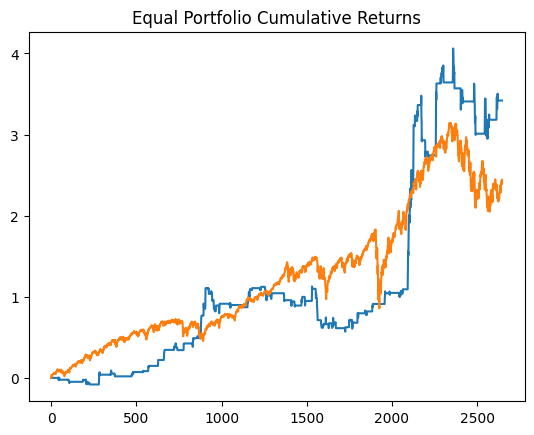

In [1843]:
ports_ff['cum_ret'].plot(title='Equal Portfolio Cumulative Returns')
ports_ff['mkt_cum_ret'].plot()

### Mean Variance Portfolio

In [1844]:
capm_eq=sm.OLS(ports_ff['portfolio_ret_mv'],
              sm.add_constant(ports_ff[['Mkt-RF']])).fit()
print(capm_eq.summary())

                            OLS Regression Results                            
Dep. Variable:       portfolio_ret_mv   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     48.34
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           4.49e-12
Time:                        22:48:12   Log-Likelihood:                -4309.1
No. Observations:                2647   AIC:                             8622.
Df Residuals:                    2645   BIC:                             8634.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0542      0.024      2.258      0.0

In [1845]:
ff3_eq=sm.OLS(ports_ff['portfolio_ret_mv'],
              sm.add_constant(ports_ff[['Mkt-RF', 'SMB', 'HML']])).fit()
print(ff3_eq.summary())

                            OLS Regression Results                            
Dep. Variable:       portfolio_ret_mv   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     19.39
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           1.97e-12
Time:                        22:48:12   Log-Likelihood:                -4304.3
No. Observations:                2647   AIC:                             8617.
Df Residuals:                    2643   BIC:                             8640.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0550      0.024      2.294      0.0

In [1846]:
ff5_eq=sm.OLS(ports_ff['portfolio_ret_mv'],
              sm.add_constant(ports_ff[['Mkt-RF', 'SMB', 'HML', 'CMA', 'RMW']])).fit()
print(ff5_eq.summary())

                            OLS Regression Results                            
Dep. Variable:       portfolio_ret_mv   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     12.10
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           1.30e-11
Time:                        22:48:12   Log-Likelihood:                -4303.1
No. Observations:                2647   AIC:                             8618.
Df Residuals:                    2641   BIC:                             8654.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0559      0.024      2.332      0.0

In [1847]:
ff6_eq=sm.OLS(ports_ff['portfolio_ret_mv'],
              sm.add_constant(ports_ff[['Mkt-RF', 'SMB', 'HML', 'CMA', 'RMW', 'MOM']])).fit()
print(ff6_eq.summary())

                            OLS Regression Results                            
Dep. Variable:       portfolio_ret_mv   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     10.14
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           4.15e-11
Time:                        22:48:12   Log-Likelihood:                -4303.0
No. Observations:                2647   AIC:                             8620.
Df Residuals:                    2640   BIC:                             8661.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0559      0.024      2.333      0.0

In [1848]:
ports_ff['cum_ret_mv'] = (1 + (ports_ff['portfolio_ret_mv'] / 100)).cumprod() - 1
ports_ff['mkt_cum_ret'] = (1 + (ports_ff['Mkt-RF'] / 100)).cumprod() - 1

<Axes: title={'center': 'Mean Variance Portfolio Cumulative Returns'}>

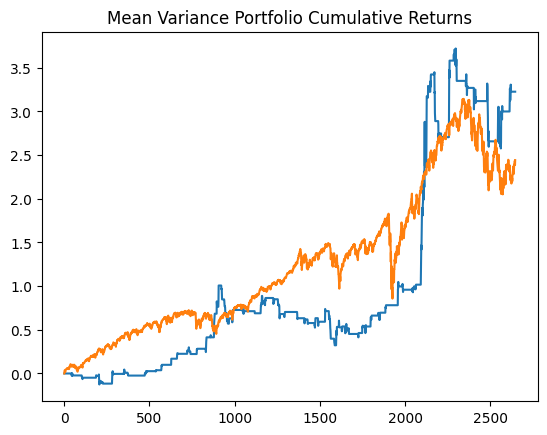

In [1849]:
ports_ff['cum_ret_mv'].plot(title='Mean Variance Portfolio Cumulative Returns')
ports_ff['mkt_cum_ret'].plot()

### Risk Parity Portfolio

In [1850]:
capm_eq=sm.OLS(ports_ff['portfolio_ret_rp'],
              sm.add_constant(ports_ff[['Mkt-RF']])).fit()
print(capm_eq.summary())

                            OLS Regression Results                            
Dep. Variable:       portfolio_ret_rp   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     46.06
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           1.41e-11
Time:                        22:48:13   Log-Likelihood:                -3937.1
No. Observations:                2647   AIC:                             7878.
Df Residuals:                    2645   BIC:                             7890.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0549      0.021      2.634      0.0

In [1851]:
ff3_eq=sm.OLS(ports_ff['portfolio_ret_rp'],
              sm.add_constant(ports_ff[['Mkt-RF', 'SMB', 'HML']])).fit()
print(ff3_eq.summary())

                            OLS Regression Results                            
Dep. Variable:       portfolio_ret_rp   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     19.95
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           8.77e-13
Time:                        22:48:13   Log-Likelihood:                -3930.3
No. Observations:                2647   AIC:                             7869.
Df Residuals:                    2643   BIC:                             7892.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0557      0.021      2.680      0.0

In [1852]:
ff5_eq=sm.OLS(ports_ff['portfolio_ret_rp'],
              sm.add_constant(ports_ff[['Mkt-RF', 'SMB', 'HML', 'CMA', 'RMW']])).fit()
print(ff5_eq.summary())

                            OLS Regression Results                            
Dep. Variable:       portfolio_ret_rp   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     12.33
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           7.66e-12
Time:                        22:48:13   Log-Likelihood:                -3929.4
No. Observations:                2647   AIC:                             7871.
Df Residuals:                    2641   BIC:                             7906.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0568      0.021      2.729      0.0

In [1853]:
ff6_eq=sm.OLS(ports_ff['portfolio_ret_rp'],
              sm.add_constant(ports_ff[['Mkt-RF', 'SMB', 'HML', 'CMA', 'RMW', 'MOM']])).fit()
print(ff6_eq.summary())

                            OLS Regression Results                            
Dep. Variable:       portfolio_ret_rp   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     10.36
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           2.27e-11
Time:                        22:48:13   Log-Likelihood:                -3929.2
No. Observations:                2647   AIC:                             7872.
Df Residuals:                    2640   BIC:                             7913.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0568      0.021      2.730      0.0

In [1854]:
alpha = [capm_eq.params.iloc[0] * 252, ff3_eq.params.iloc[0] * 252, ff5_eq.params.iloc[0] * 252, ff6_eq.params.iloc[0] * 252]
beta = [capm_eq.params.iloc[1] * 252, ff3_eq.params.iloc[1] * 252, ff5_eq.params.iloc[1] * 252, ff6_eq.params.iloc[1] * 252]

alpha = [f'${float(i)}$\%' for i in alpha]
beta = [f'${float(i)}$\%' for i in beta]

alpha, beta

(['$13.836309488605801$\\%',
  '$14.047346439688694$\\%',
  '$14.317160623977971$\\%',
  '$14.323815929692346$\\%'],
 ['$31.758108363544892$\\%',
  '$28.10293988899312$\\%',
  '$25.955310569647175$\\%',
  '$25.8264308236205$\\%'])

In [1855]:
ports_ff['cum_ret_rp'] = (1 + (ports_ff['portfolio_ret_rp'] / 100)).cumprod() - 1
ports_ff['mkt_cum_ret'] = (1 + (ports_ff['Mkt-RF'] / 100)).cumprod() - 1

<Axes: title={'center': 'Risk Parity Portfolio Cumulative Returns'}>

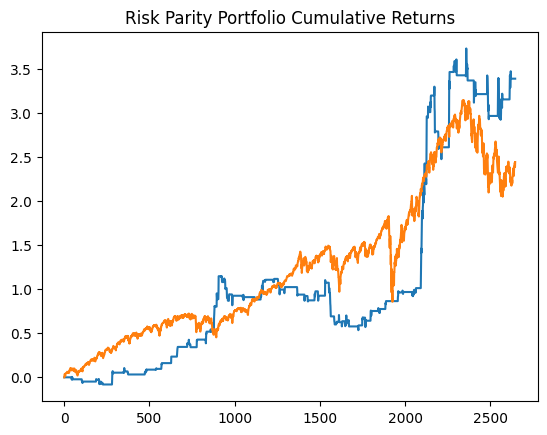

In [1856]:
ports_ff['cum_ret_rp'].plot(title='Risk Parity Portfolio Cumulative Returns')
ports_ff['mkt_cum_ret'].plot()

In [1858]:
vol_ret = pd.read_csv('./volume_weighted_after_hours_l.csv')
vol_ret = vol_ret.rename({'Date' : 'date', 'Cum_Returns' : 'cum_ret_vol'}, axis=1)

In [1705]:
vol_ret = pd.read_csv('./volume_weighted_next_day_l.csv')
vol_ret = vol_ret.rename({'Date' : 'date', 'Cum_Returns' : 'cum_ret_vol_long_next'}, axis=1)

In [1859]:
vol_ret['date'] = vol_ret['date'].astype(str).str.replace('-', '').astype(int)

In [1860]:
vol_ret['cum_ret_vol'] = vol_ret['cum_ret_vol'] - 1

In [1861]:
ports_ff['date'] = ports_ff['date'].astype(str).str.replace('-', '').astype(int)

In [1862]:
ports_ff = pd.merge(ports_ff, vol_ret,  how='left', on='date')

In [1863]:
ports_ff

,date,portfolio_ret,portfolio_ret_mv,portfolio_ret_rp,Mkt-RF,SMB,HML,RMW,CMA,MOM,RF,cum_ret,mkt_cum_ret,cum_ret_mv,cum_ret_rp,cum_ret_vol
0,20120725,0.0,0.0,0.0,-0.01,0.23,0.00,-0.52,0.06,-0.20,0.000,0.000000,-0.000100,0.000000,0.000000,NaN
1,20120726,0.0,0.0,0.0,1.53,-0.80,0.34,0.07,0.27,-0.64,0.000,0.000000,0.015198,0.000000,0.000000,NaN
2,20120727,0.0,0.0,0.0,1.96,0.55,0.07,-0.17,-0.35,-0.96,0.000,0.000000,0.035096,0.000000,0.000000,NaN
3,20120730,0.0,0.0,0.0,-0.13,-0.40,0.23,0.22,0.32,0.05,0.000,0.000000,0.033751,0.000000,0.000000,NaN
4,20120731,0.0,0.0,0.0,-0.47,0.00,0.20,0.47,0.01,-0.14,0.000,0.000000,0.028892,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2642,20230125,0.0,0.0,0.0,0.00,0.13,0.65,0.02,0.22,0.14,0.017,3.419166,2.387341,3.226657,3.388579,3.246004
2643,20230126,0.0,0.0,0.0,1.08,-0.62,0.01,-0.19,-0.33,-1.23,0.017,3.419166,2.423924,3.226657,3.388579,3.246004
2644,20230127,0.0,0.0,0.0,0.36,0.32,-1.16,-0.61,-1.18,-2.46,0.017,3.419166,2.436250,3.226657,3.388579,3.246004
2645,20230130,0.0,0.0,0.0,-1.38,0.05,0.72,0.40,0.81,1.36,0.017,3.419166,2.388830,3.226657,3.388579,3.246004


In [1864]:
ports_ff['date'] = pd.to_datetime(ports_ff['date'], format='%Y%m%d')

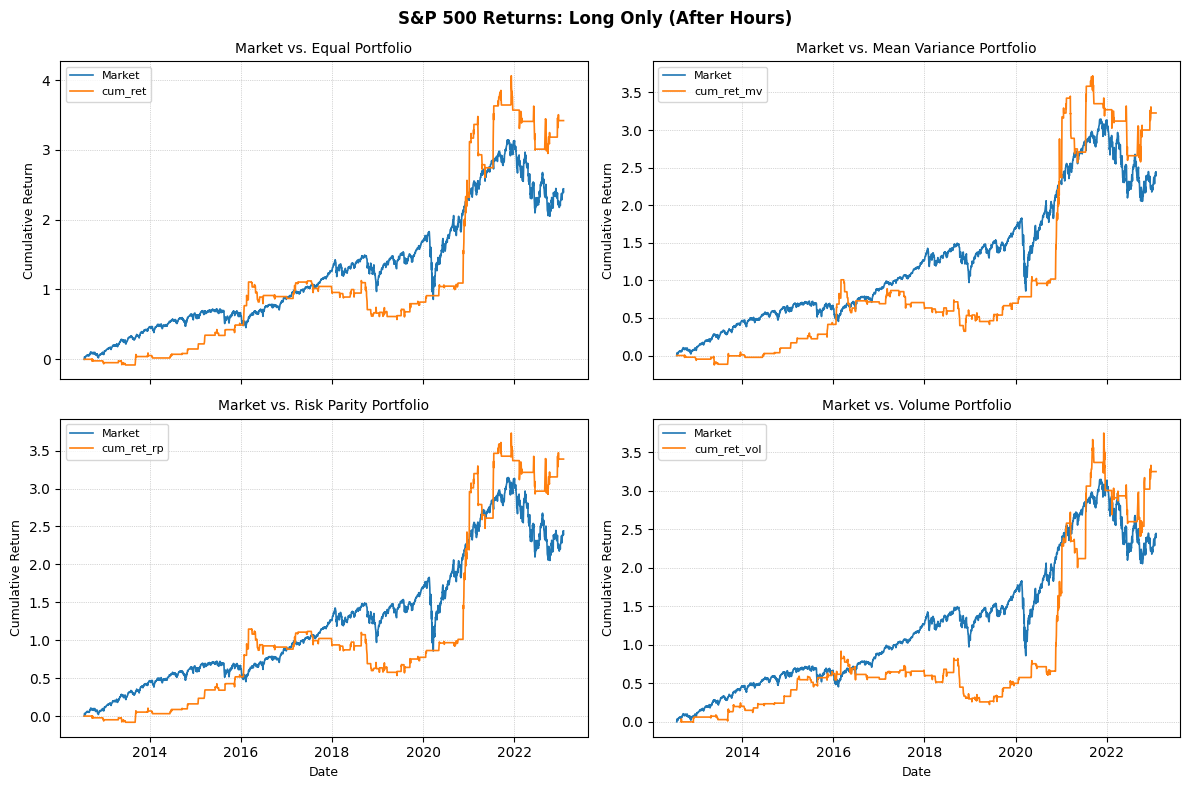

In [1865]:
pairs = [
    ("cum_ret",     "Market vs. Equal Portfolio"),
    ("cum_ret_mv",  "Market vs. Mean Variance Portfolio"),
    ("cum_ret_rp",  "Market vs. Risk Parity Portfolio"),
    ("cum_ret_vol", "Market vs. Volume Portfolio")
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True)

axes = axes.flatten()

for idx, (col, title) in enumerate(pairs):
    ax = axes[idx]
    
    sns.lineplot(
        data=ports_ff,
        x="date",
        y="mkt_cum_ret",
        label="Market",
        ax=ax,
        linewidth=1.2
    )
    
    sns.lineplot(
        data=ports_ff,
        x="date",
        y=col,
        label=col,
        ax=ax,
        linewidth=1.2
    )
    
    ax.set_title(title, fontsize=10)
    ax.set_ylabel("Cumulative Return", fontsize=9)
    ax.legend(title="", fontsize=8)
    ax.grid(True, linestyle=":", linewidth=0.5)
    
    if idx >= 2:
        ax.set_xlabel("Date", fontsize=9)
    else:
        ax.set_xlabel("")

fig.suptitle('S&P 500 Returns: Long Only (After Hours)', fontweight="bold")
plt.tight_layout()
plt.show()

# Others

In [1470]:
others = events[~(events['Index'].astype(str).str.contains('S&P 500', na=False))].reset_index()

In [422]:
others = others.drop(['index', 'level_0'], axis=1)

In [423]:
others

,date,Index,Action,Company,Ticker,Sector,URL,Announced Date
0,20120731,S&P SMALLCAP 600 INDEX,Del,GeoResources,GEOI,Energy,https://press.spglobal.com/2012-07-25-SolarWin...,20120725
1,20120731,S&P SMALLCAP 600 INDEX,Add,HealthStream,HSTM,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,20120725
2,20120731,S&P MIDCAP 400 INDEX,Del,Gen-Probe,GPRO,Health Care,https://press.spglobal.com/2012-07-25-SolarWin...,20120725
3,20120731,S&P MIDCAP 400 INDEX,Add,SolarWinds,SWI,Information Technology,https://press.spglobal.com/2012-07-25-SolarWin...,20120725
4,20120803,S&P SMALLCAP 600 INDEX,Del,Standard Microsystems,SMSC,Information Technology,https://press.spglobal.com/2012-08-01-Jarden-t...,20120801
...,...,...,...,...,...,...,...,...
2634,20250417,S&P SmallCap 600,Add,Sterling Infrastructure,STRL,Industrials,https://press.spglobal.com/2025-04-14-Sterling...,20250414
2635,20250501,S&P MidCap 400,Del,Berry Global Group,BERY,Materials,https://press.spglobal.com/2025-04-28-Okta-Set...,20250428
2636,20250501,S&P MidCap 400,Add,Okta,OKTA,Information Technology,https://press.spglobal.com/2025-04-28-Okta-Set...,20250428
2637,20250522,S&P MidCap 400,Del,Nordstrom,JWN,Consumer Discretionary,https://press.spglobal.com/2025-05-19-Pegasyst...,20250519


In [424]:
portfolio = pd.DataFrame()
no_data = []
for row in others.iterrows():
    tckr = row[1]['Ticker']
    start_date = row[1]['Announced Date']
    end_date = row[1]['date']
    returns_within_range = get_return(tckr, start_date, end_date)
    if returns_within_range.empty:
        no_data.append({'Ticker': tckr,
                        'Action': row[1]['Action'],
                        'Company': row[1]['Company']})
    returns_within_range['Action'] = row[1]['Action']
    portfolio = pd.concat([portfolio, returns_within_range], ignore_index=True)

In [425]:
portfolio['LS'] = portfolio['Action'].apply(lambda x : 1 if x == 'Add' else -1 )
portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)
portfolio['portfolio_ret'] = portfolio['weight'] * portfolio['RET']

/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/716949959.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)


In [426]:
eqports = portfolio.groupby(['date'])['portfolio_ret'].sum()
eqports = eqports.dropna(axis=0)
eqports = eqports * 100
eqports = eqports.reset_index()

In [427]:
eqports[eqports['portfolio_ret'] == 0].count() / len(eqports)

date             0.054997
portfolio_ret    0.054997
dtype: float64

In [428]:
stratmean = eqports['portfolio_ret'].mean()
stratvol = eqports['portfolio_ret'].std()
stratsharpe = stratmean/stratvol

In [429]:
print("{} has mean {}, vol {}, and Sharpe {}".format('Equal Portfolio', stratmean, stratvol, stratsharpe))

Equal Portfolio has mean 0.814509513702078, vol 2.6506657892145156, and Sharpe 0.3072848780167965


In [430]:
eqports_ff = pd.merge(eqports, ff6, how='left', on='date')
eqports_ff = eqports_ff.dropna()
eqports_ff['Mkt-RF'] = pd.to_numeric(eqports_ff['Mkt-RF'], errors='coerce')
eqports_ff['SMB'] = pd.to_numeric(eqports_ff['SMB'], errors='coerce')
eqports_ff['HML'] = pd.to_numeric(eqports_ff['HML'], errors='coerce')
eqports_ff['RMW'] = pd.to_numeric(eqports_ff['RMW'], errors='coerce')
eqports_ff['CMA'] = pd.to_numeric(eqports_ff['CMA'], errors='coerce')
eqports_ff['MOM'] = pd.to_numeric(eqports_ff['MOM'], errors='coerce')
eqports_ff['RF'] = pd.to_numeric(eqports_ff['RF'], errors='coerce')

In [431]:
capm_eq=sm.OLS(eqports_ff['portfolio_ret'],
              sm.add_constant(eqports_ff[['Mkt-RF']])).fit()
print(capm_eq.summary())

                            OLS Regression Results                            
Dep. Variable:          portfolio_ret   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     18.11
Date:                Fri, 30 May 2025   Prob (F-statistic):           2.23e-05
Time:                        23:44:58   Log-Likelihood:                -3241.4
No. Observations:                1365   AIC:                             6487.
Df Residuals:                    1363   BIC:                             6497.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8380      0.070     11.886      0.0

In [432]:
ff3_eq=sm.OLS(eqports_ff['portfolio_ret'],
              sm.add_constant(eqports_ff[['Mkt-RF', 'SMB', 'HML']])).fit()
print(ff3_eq.summary())

                            OLS Regression Results                            
Dep. Variable:          portfolio_ret   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     8.830
Date:                Fri, 30 May 2025   Prob (F-statistic):           8.48e-06
Time:                        23:44:58   Log-Likelihood:                -3237.2
No. Observations:                1365   AIC:                             6482.
Df Residuals:                    1361   BIC:                             6503.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8352      0.070     11.873      0.0

In [433]:
ff5_eq=sm.OLS(eqports_ff['portfolio_ret'],
              sm.add_constant(eqports_ff[['Mkt-RF', 'SMB', 'HML', 'CMA', 'RMW']])).fit()
print(ff5_eq.summary())

                            OLS Regression Results                            
Dep. Variable:          portfolio_ret   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     5.381
Date:                Fri, 30 May 2025   Prob (F-statistic):           6.61e-05
Time:                        23:44:58   Log-Likelihood:                -3237.0
No. Observations:                1365   AIC:                             6486.
Df Residuals:                    1359   BIC:                             6517.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8372      0.070     11.879      0.0

In [434]:
ff6_eq=sm.OLS(eqports_ff['portfolio_ret'],
              sm.add_constant(eqports_ff[['Mkt-RF', 'SMB', 'HML', 'CMA', 'RMW', 'MOM']])).fit()
print(ff6_eq.summary())

                            OLS Regression Results                            
Dep. Variable:          portfolio_ret   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     4.881
Date:                Fri, 30 May 2025   Prob (F-statistic):           6.04e-05
Time:                        23:44:58   Log-Likelihood:                -3235.8
No. Observations:                1365   AIC:                             6486.
Df Residuals:                    1358   BIC:                             6522.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8369      0.070     11.882      0.0

In [435]:
eqports_ff['cum_ret'] = (1 + (eqports_ff['portfolio_ret'] / 100)).cumprod() - 1
eqports_ff['mkt_cum_ret'] = (1 + (eqports_ff['Mkt-RF'] / 100)).cumprod() - 1

In [436]:
eqports_ff

,date,portfolio_ret,Mkt-RF,SMB,HML,RMW,CMA,MOM,RF,cum_ret,mkt_cum_ret
0,20120726,4.346533,1.53,-0.80,0.34,0.07,0.27,-0.64,0.000,0.043465,0.015300
1,20120727,1.652000,1.96,0.55,0.07,-0.17,-0.35,-0.96,0.000,0.060703,0.035200
2,20120730,-0.372833,-0.13,-0.40,0.23,0.22,0.32,0.05,0.000,0.056749,0.033854
3,20120731,-0.631533,-0.47,0.00,0.20,0.47,0.01,-0.14,0.000,0.050075,0.028995
4,20120802,1.950400,-0.69,0.17,-0.34,-0.03,0.00,1.21,0.000,0.070556,0.021895
...,...,...,...,...,...,...,...,...,...,...,...
1360,20230105,-1.184300,-1.14,0.15,1.20,0.77,0.80,1.23,0.017,63877.577988,0.693040
1361,20230126,4.156850,1.08,-0.62,0.01,-0.19,-0.33,-1.23,0.017,66532.914657,0.711325
1362,20230127,1.002600,0.36,0.32,-1.16,-0.61,-1.18,-2.46,0.017,67199.983685,0.717486
1363,20230130,-1.404775,-1.38,0.05,0.72,0.40,0.81,1.36,0.017,66255.961067,0.693785


<Axes: title={'center': 'Equal Portfolio Cumulative Returns'}>

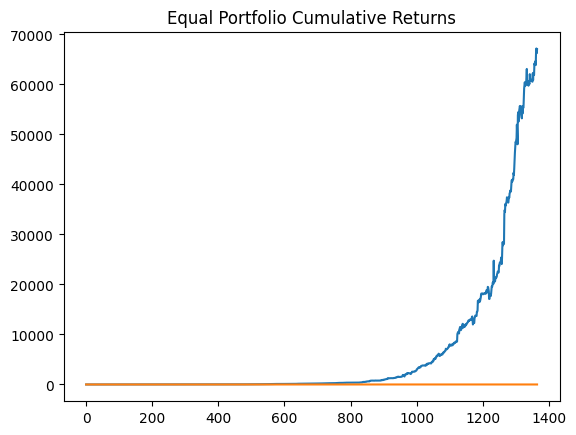

In [437]:
eqports_ff['cum_ret'].plot(title='Equal Portfolio Cumulative Returns')
eqports_ff['mkt_cum_ret'].plot()

# Summary

In [463]:
divider = "=" * 169

/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/2842040623.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)


S&P 500 ratio: date             0.05709
portfolio_ret    0.05709
dtype: float64
Equal Portfolio has mean 0.23906464022625618, vol 2.4802772631555072, and Sharpe 0.09638625639865304
S&P 500 CAPM
                            OLS Regression Results                            
Dep. Variable:          portfolio_ret   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4430
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.506
Time:                        00:22:29   Log-Likelihood:                -1132.9
No. Observations:                 486   AIC:                             2270.
Df Residuals:                     484   BIC:                             2278.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                

/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/2842040623.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)


S&P SMALLCAP 600 ratio: date             0.02075
portfolio_ret    0.02075
dtype: float64
Equal Portfolio has mean 1.2577486744845807, vol 3.5189604635277827, and Sharpe 0.3574205187925524
S&P SMALLCAP 600 CAPM
                            OLS Regression Results                            
Dep. Variable:          portfolio_ret   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     12.98
Date:                Sat, 31 May 2025   Prob (F-statistic):           0.000328
Time:                        00:22:49   Log-Likelihood:                -3040.5
No. Observations:                1137   AIC:                             6085.
Df Residuals:                    1135   BIC:                             6095.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         


/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/2842040623.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)


S&P MIDCAP 400 ratio: date             0.040346
portfolio_ret    0.040346
dtype: float64
Equal Portfolio has mean 0.025460570854920275, vol 2.6401636402703104, and Sharpe 0.00964355787140282
S&P MIDCAP 400 CAPM
                            OLS Regression Results                            
Dep. Variable:          portfolio_ret   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5681
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.451
Time:                        00:23:03   Log-Likelihood:                -2281.7
No. Observations:                 947   AIC:                             4567.
Df Residuals:                     945   BIC:                             4577.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         

/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/2842040623.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)
/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/2842040623.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index

DJIA ratio: date             0.0
portfolio_ret    0.0
dtype: float64
Equal Portfolio has mean 0.11177239583333333, vol 1.9829412647348281, and Sharpe 0.05636697254786327
DJIA CAPM
                            OLS Regression Results                            
Dep. Variable:          portfolio_ret   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                    0.2031
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.656
Time:                        00:23:03   Log-Likelihood:                -66.697
No. Observations:                  32   AIC:                             137.4
Df Residuals:                      30   BIC:                             140.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std e

/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/2842040623.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)
/opt/homeb

DJTA ratio: date             0.0
portfolio_ret    0.0
dtype: float64
Equal Portfolio has mean 0.8449545454545454, vol 2.0188257015471325, and Sharpe 0.4185376403752995
DJTA CAPM
                            OLS Regression Results                            
Dep. Variable:          portfolio_ret   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.072
Method:                 Least Squares   F-statistic:                    0.3267
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.582
Time:                        00:23:03   Log-Likelihood:                -22.616
No. Observations:                  11   AIC:                             49.23
Df Residuals:                       9   BIC:                             50.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err

/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/2842040623.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)
/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/2842040623.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index

S&P 100 ratio: date             0.0
portfolio_ret    0.0
dtype: float64
Equal Portfolio has mean 0.09823578431372554, vol 2.0166813693657057, and Sharpe 0.04871160402727528
S&P 100 CAPM
                            OLS Regression Results                            
Dep. Variable:          portfolio_ret   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     11.35
Date:                Sat, 31 May 2025   Prob (F-statistic):            0.00111
Time:                        00:23:04   Log-Likelihood:                -193.23
No. Observations:                  92   AIC:                             390.5
Df Residuals:                      90   BIC:                             395.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef   

/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/2842040623.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)
/opt/homebre

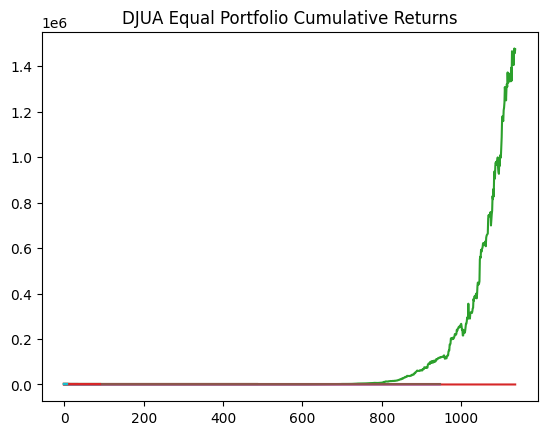

In [466]:
for idx in events['Index'].unique():
    others = events[events['Index'] == idx].reset_index()
    others = others.drop(['index', 'level_0'], axis=1)

    portfolio = pd.DataFrame()
    no_data = []
    for row in others.iterrows():
        tckr = row[1]['Ticker']
        start_date = row[1]['Announced Date']
        end_date = row[1]['date']
        returns_within_range = get_return(tckr, start_date, end_date)
        if returns_within_range.empty:
            no_data.append({'Ticker': tckr,
                            'Action': row[1]['Action'],
                            'Company': row[1]['Company']})
        returns_within_range['Action'] = row[1]['Action']
        portfolio = pd.concat([portfolio, returns_within_range], ignore_index=True)
    portfolio['LS'] = portfolio['Action'].apply(lambda x : 1 if x == 'Add' else -1 )
    portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)
    portfolio['portfolio_ret'] = portfolio['weight'] * portfolio['RET']

    eqports = portfolio.groupby(['date'])['portfolio_ret'].sum()
    eqports = eqports.dropna(axis=0)
    eqports = eqports * 100
    eqports = eqports.reset_index()
    ratio = eqports[eqports['portfolio_ret'] == 0].count() / len(eqports)
    print(f'{idx} ratio: {ratio}')

    stratmean = eqports['portfolio_ret'].mean()
    stratvol = eqports['portfolio_ret'].std()
    stratsharpe = stratmean/stratvol
    print("{} has mean {}, vol {}, and Sharpe {}".format('Equal Portfolio', stratmean, stratvol, stratsharpe))
    print(divider)
    eqports_ff = pd.merge(eqports, ff6, how='left', on='date')
    eqports_ff = eqports_ff.dropna()
    eqports_ff['Mkt-RF'] = pd.to_numeric(eqports_ff['Mkt-RF'], errors='coerce')
    eqports_ff['SMB'] = pd.to_numeric(eqports_ff['SMB'], errors='coerce')
    eqports_ff['HML'] = pd.to_numeric(eqports_ff['HML'], errors='coerce')
    eqports_ff['RMW'] = pd.to_numeric(eqports_ff['RMW'], errors='coerce')
    eqports_ff['CMA'] = pd.to_numeric(eqports_ff['CMA'], errors='coerce')
    eqports_ff['MOM'] = pd.to_numeric(eqports_ff['MOM'], errors='coerce')
    eqports_ff['RF'] = pd.to_numeric(eqports_ff['RF'], errors='coerce')

    capm_eq=sm.OLS(eqports_ff['portfolio_ret'],
                sm.add_constant(eqports_ff[['Mkt-RF']])).fit()
    print(f'{idx} CAPM')
    print(capm_eq.summary())
    ff3_eq=sm.OLS(eqports_ff['portfolio_ret'],
                sm.add_constant(eqports_ff[['Mkt-RF', 'SMB', 'HML']])).fit()
    print(divider)

    print(f'{idx} FF3')
    print(ff3_eq.summary())
    ff5_eq=sm.OLS(eqports_ff['portfolio_ret'],
                sm.add_constant(eqports_ff[['Mkt-RF', 'SMB', 'HML', 'CMA', 'RMW']])).fit()
    print(ff5_eq.summary())
    print(divider)

    print(f'{idx} FF5')
    ff6_eq=sm.OLS(eqports_ff['portfolio_ret'],
                sm.add_constant(eqports_ff[['Mkt-RF', 'SMB', 'HML', 'CMA', 'RMW', 'MOM']])).fit()
    print(ff6_eq.summary())
    print(divider)
    print(f'{idx} FF6')

    eqports_ff['cum_ret'] = (1 + (eqports_ff['portfolio_ret'] / 100)).cumprod() - 1
    eqports_ff['mkt_cum_ret'] = (1 + (eqports_ff['Mkt-RF'] / 100)).cumprod() - 1
    eqports_ff
    eqports_ff['cum_ret'].plot(title=f'{idx} Equal Portfolio Cumulative Returns')
    eqports_ff['mkt_cum_ret'].plot()
    print(divider)
    print(divider)
    print(divider)

In [ ]:
/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/2842040623.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)
S&P 500 ratio: date             0.05709
portfolio_ret    0.05709
dtype: float64
Equal Portfolio has mean 0.23906464022625618, vol 2.4802772631555072, and Sharpe 0.09638625639865304
=========================================================================================================================================================================
S&P 500 CAPM
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4430
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.506
Time:                        00:22:29   Log-Likelihood:                -1132.9
No. Observations:                 486   AIC:                             2270.
Df Residuals:                     484   BIC:                             2278.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1714      0.113      1.513      0.131      -0.051       0.394
Mkt-RF        -0.0683      0.103     -0.666      0.506      -0.270       0.133
==============================================================================
Omnibus:                       89.149   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1142.019
Skew:                          -0.311   Prob(JB):                    1.03e-248
Kurtosis:                      10.484   Cond. No.                         1.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
S&P 500 FF3
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     3.123
Date:                Sat, 31 May 2025   Prob (F-statistic):             0.0257
Time:                        00:22:30   Log-Likelihood:                -1128.4
No. Observations:                 486   AIC:                             2265.
Df Residuals:                     482   BIC:                             2282.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1449      0.113      1.283      0.200      -0.077       0.367
Mkt-RF        -0.1181      0.106     -1.112      0.267      -0.327       0.090
SMB            0.2150      0.199      1.079      0.281      -0.177       0.607
HML           -0.4388      0.149     -2.950      0.003      -0.731      -0.147
==============================================================================
Omnibus:                       88.888   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1184.373
Skew:                          -0.283   Prob(JB):                    6.56e-258
Kurtosis:                      10.627   Cond. No.                         2.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.487
Date:                Sat, 31 May 2025   Prob (F-statistic):             0.0307
Time:                        00:22:30   Log-Likelihood:                -1126.9
No. Observations:                 486   AIC:                             2266.
Df Residuals:                     480   BIC:                             2291.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1419      0.113      1.254      0.210      -0.080       0.364
Mkt-RF        -0.1501      0.108     -1.390      0.165      -0.362       0.062
SMB            0.1073      0.209      0.514      0.607      -0.303       0.517
HML           -0.2452      0.193     -1.273      0.204      -0.623       0.133
CMA           -0.4273      0.364     -1.174      0.241      -1.143       0.288
RMW           -0.3392      0.257     -1.320      0.187      -0.844       0.166
==============================================================================
Omnibus:                       85.324   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1079.147
Skew:                          -0.257   Prob(JB):                    4.64e-235
Kurtosis:                      10.282   Cond. No.                         3.94
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
S&P 500 FF5
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.086
Date:                Sat, 31 May 2025   Prob (F-statistic):             0.0535
Time:                        00:22:30   Log-Likelihood:                -1126.8
No. Observations:                 486   AIC:                             2268.
Df Residuals:                     479   BIC:                             2297.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1414      0.113      1.249      0.212      -0.081       0.364
Mkt-RF        -0.1467      0.109     -1.351      0.177      -0.360       0.067
SMB            0.1169      0.211      0.554      0.580      -0.298       0.532
HML           -0.2222      0.205     -1.081      0.280      -0.626       0.182
CMA           -0.4543      0.374     -1.215      0.225      -1.189       0.280
RMW           -0.3324      0.258     -1.288      0.198      -0.839       0.175
MOM            0.0430      0.133      0.323      0.747      -0.219       0.305
==============================================================================
Omnibus:                       85.599   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1098.507
Skew:                          -0.252   Prob(JB):                    2.90e-239
Kurtosis:                      10.348   Cond. No.                         4.15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
S&P 500 FF6
=========================================================================================================================================================================
=========================================================================================================================================================================
=========================================================================================================================================================================
/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/2842040623.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)
S&P SMALLCAP 600 ratio: date             0.02075
portfolio_ret    0.02075
dtype: float64
Equal Portfolio has mean 1.2577486744845807, vol 3.5189604635277827, and Sharpe 0.3574205187925524
=========================================================================================================================================================================
S&P SMALLCAP 600 CAPM
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     12.98
Date:                Sat, 31 May 2025   Prob (F-statistic):           0.000328
Time:                        00:22:49   Log-Likelihood:                -3040.5
No. Observations:                1137   AIC:                             6085.
Df Residuals:                    1135   BIC:                             6095.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3064      0.104     12.540      0.000       1.102       1.511
Mkt-RF         0.3275      0.091      3.603      0.000       0.149       0.506
==============================================================================
Omnibus:                      356.964   Durbin-Watson:                   2.306
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1921.720
Skew:                           1.347   Prob(JB):                         0.00
Kurtosis:                       8.771   Cond. No.                         1.15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
S&P SMALLCAP 600 FF3
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     5.859
Date:                Sat, 31 May 2025   Prob (F-statistic):           0.000571
Time:                        00:22:49   Log-Likelihood:                -3038.2
No. Observations:                1137   AIC:                             6084.
Df Residuals:                    1133   BIC:                             6105.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3037      0.104     12.526      0.000       1.100       1.508
Mkt-RF         0.2869      0.093      3.086      0.002       0.104       0.469
SMB            0.2532      0.170      1.492      0.136      -0.080       0.586
HML           -0.2256      0.125     -1.812      0.070      -0.470       0.019
==============================================================================
Omnibus:                      351.975   Durbin-Watson:                   2.300
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1779.952
Skew:                           1.348   Prob(JB):                         0.00
Kurtosis:                       8.505   Cond. No.                         1.95
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     3.652
Date:                Sat, 31 May 2025   Prob (F-statistic):            0.00278
Time:                        00:22:49   Log-Likelihood:                -3037.8
No. Observations:                1137   AIC:                             6088.
Df Residuals:                    1131   BIC:                             6118.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3016      0.104     12.485      0.000       1.097       1.506
Mkt-RF         0.3101      0.098      3.173      0.002       0.118       0.502
SMB            0.2655      0.183      1.452      0.147      -0.093       0.624
HML           -0.3135      0.173     -1.815      0.070      -0.652       0.025
CMA            0.2759      0.329      0.838      0.402      -0.370       0.922
RMW           -0.0207      0.242     -0.085      0.932      -0.496       0.455
==============================================================================
Omnibus:                      348.973   Durbin-Watson:                   2.300
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1752.957
Skew:                           1.337   Prob(JB):                         0.00
Kurtosis:                       8.464   Cond. No.                         3.99
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
S&P SMALLCAP 600 FF5
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     4.035
Date:                Sat, 31 May 2025   Prob (F-statistic):           0.000523
Time:                        00:22:49   Log-Likelihood:                -3034.9
No. Observations:                1137   AIC:                             6084.
Df Residuals:                    1130   BIC:                             6119.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3020      0.104     12.517      0.000       1.098       1.506
Mkt-RF         0.2951      0.098      3.020      0.003       0.103       0.487
SMB            0.1869      0.185      1.009      0.313      -0.177       0.551
HML           -0.4780      0.185     -2.580      0.010      -0.842      -0.115
CMA            0.5184      0.344      1.509      0.132      -0.156       1.192
RMW           -0.0206      0.242     -0.085      0.932      -0.495       0.454
MOM           -0.2669      0.110     -2.424      0.016      -0.483      -0.051
==============================================================================
Omnibus:                      338.028   Durbin-Watson:                   2.294
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1584.885
Skew:                           1.314   Prob(JB):                         0.00
Kurtosis:                       8.152   Cond. No.                         4.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
S&P SMALLCAP 600 FF6
=========================================================================================================================================================================
=========================================================================================================================================================================
=========================================================================================================================================================================
/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/2842040623.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)
S&P MIDCAP 400 ratio: date             0.040346
portfolio_ret    0.040346
dtype: float64
Equal Portfolio has mean 0.025460570854920275, vol 2.6401636402703104, and Sharpe 0.00964355787140282
=========================================================================================================================================================================
S&P MIDCAP 400 CAPM
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5681
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.451
Time:                        00:23:03   Log-Likelihood:                -2281.7
No. Observations:                 947   AIC:                             4567.
Df Residuals:                     945   BIC:                             4577.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0463      0.088      0.529      0.597      -0.126       0.218
Mkt-RF         0.0656      0.087      0.754      0.451      -0.105       0.237
==============================================================================
Omnibus:                      175.462   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1656.350
Skew:                          -0.544   Prob(JB):                         0.00
Kurtosis:                       9.387   Cond. No.                         1.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
S&P MIDCAP 400 FF3
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.201
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.308
Time:                        00:23:03   Log-Likelihood:                -2280.2
No. Observations:                 947   AIC:                             4568.
Df Residuals:                     943   BIC:                             4588.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0506      0.088      0.577      0.564      -0.121       0.223
Mkt-RF         0.1021      0.091      1.121      0.263      -0.077       0.281
SMB           -0.2513      0.146     -1.726      0.085      -0.537       0.034
HML            0.0281      0.106      0.266      0.790      -0.179       0.235
==============================================================================
Omnibus:                      174.251   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1647.977
Skew:                          -0.537   Prob(JB):                         0.00
Kurtosis:                       9.373   Cond. No.                         1.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7912
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.556
Time:                        00:23:03   Log-Likelihood:                -2280.0
No. Observations:                 947   AIC:                             4572.
Df Residuals:                     941   BIC:                             4601.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0479      0.088      0.545      0.586      -0.125       0.220
Mkt-RF         0.1160      0.096      1.213      0.225      -0.072       0.304
SMB           -0.2217      0.155     -1.430      0.153      -0.526       0.083
HML           -0.0216      0.140     -0.155      0.877      -0.296       0.253
CMA            0.0911      0.266      0.342      0.732      -0.432       0.614
RMW            0.0931      0.202      0.460      0.645      -0.304       0.490
==============================================================================
Omnibus:                      175.134   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1645.740
Skew:                          -0.544   Prob(JB):                         0.00
Kurtosis:                       9.366   Cond. No.                         3.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
S&P MIDCAP 400 FF5
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8241
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.551
Time:                        00:23:03   Log-Likelihood:                -2279.5
No. Observations:                 947   AIC:                             4573.
Df Residuals:                     940   BIC:                             4607.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0464      0.088      0.528      0.598      -0.126       0.219
Mkt-RF         0.1260      0.096      1.310      0.190      -0.063       0.315
SMB           -0.1874      0.159     -1.180      0.238      -0.499       0.124
HML            0.0355      0.151      0.235      0.815      -0.261       0.332
CMA            0.0079      0.279      0.028      0.977      -0.540       0.556
RMW            0.1092      0.203      0.538      0.590      -0.289       0.507
MOM            0.0908      0.091      0.994      0.320      -0.088       0.270
==============================================================================
Omnibus:                      175.440   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1637.302
Skew:                          -0.548   Prob(JB):                         0.00
Kurtosis:                       9.348   Cond. No.                         4.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
S&P MIDCAP 400 FF6
=========================================================================================================================================================================
=========================================================================================================================================================================
=========================================================================================================================================================================
/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/2842040623.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)
/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/2842040623.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)
DJIA ratio: date             0.0
portfolio_ret    0.0
dtype: float64
Equal Portfolio has mean 0.11177239583333333, vol 1.9829412647348281, and Sharpe 0.05636697254786327
=========================================================================================================================================================================
DJIA CAPM
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                    0.2031
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.656
Time:                        00:23:03   Log-Likelihood:                -66.697
No. Observations:                  32   AIC:                             137.4
Df Residuals:                      30   BIC:                             140.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1473      0.364      0.405      0.688      -0.596       0.890
Mkt-RF        -0.2368      0.526     -0.451      0.656      -1.310       0.837
==============================================================================
Omnibus:                       25.640   Durbin-Watson:                   2.378
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.769
Skew:                          -1.466   Prob(JB):                     1.75e-18
Kurtosis:                      10.262   Cond. No.                         1.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
DJIA FF3
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     3.253
Date:                Sat, 31 May 2025   Prob (F-statistic):             0.0365
Time:                        00:23:03   Log-Likelihood:                -62.020
No. Observations:                  32   AIC:                             132.0
Df Residuals:                      28   BIC:                             137.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1827      0.341      0.536      0.596      -0.516       0.881
Mkt-RF        -0.5661      0.483     -1.173      0.251      -1.554       0.422
SMB           -1.8694      0.682     -2.740      0.011      -3.267      -0.472
HML           -0.1759      0.593     -0.297      0.769      -1.390       1.038
==============================================================================
Omnibus:                       30.146   Durbin-Watson:                   2.433
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.470
Skew:                          -2.007   Prob(JB):                     1.51e-17
Kurtosis:                       9.479   Cond. No.                         2.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     4.144
Date:                Sat, 31 May 2025   Prob (F-statistic):            0.00669
Time:                        00:23:03   Log-Likelihood:                -57.428
No. Observations:                  32   AIC:                             126.9
Df Residuals:                      26   BIC:                             135.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0336      0.313      0.107      0.915      -0.610       0.677
Mkt-RF        -0.3800      0.457     -0.832      0.413      -1.319       0.559
SMB           -1.5633      0.632     -2.473      0.020      -2.863      -0.264
HML            0.2367      0.672      0.353      0.727      -1.144       1.617
CMA           -2.6549      1.126     -2.357      0.026      -4.970      -0.340
RMW            0.8188      1.075      0.762      0.453      -1.390       3.028
==============================================================================
Omnibus:                       32.625   Durbin-Watson:                   2.516
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.023
Skew:                          -2.148   Prob(JB):                     6.31e-21
Kurtosis:                      10.163   Cond. No.                         5.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
DJIA FF5
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     3.958
Date:                Sat, 31 May 2025   Prob (F-statistic):            0.00642
Time:                        00:23:03   Log-Likelihood:                -56.119
No. Observations:                  32   AIC:                             126.2
Df Residuals:                      25   BIC:                             136.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0386      0.307      0.126      0.901      -0.593       0.670
Mkt-RF        -0.3203      0.449     -0.713      0.482      -1.245       0.605
SMB           -1.4306      0.625     -2.287      0.031      -2.719      -0.142
HML            0.8215      0.770      1.067      0.296      -0.764       2.407
CMA           -2.5243      1.106     -2.282      0.031      -4.803      -0.246
RMW            1.6182      1.186      1.364      0.185      -0.824       4.061
MOM            0.8179      0.560      1.460      0.157      -0.336       1.972
==============================================================================
Omnibus:                       37.197   Durbin-Watson:                   2.568
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.389
Skew:                          -2.420   Prob(JB):                     2.18e-28
Kurtosis:                      11.492   Cond. No.                         5.56
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
DJIA FF6
=========================================================================================================================================================================
=========================================================================================================================================================================
=========================================================================================================================================================================
S&P 400 ratio: date             0.0
portfolio_ret    0.0
dtype: float64
Equal Portfolio has mean 1.7217416666666665, vol 3.286155642155389, and Sharpe 0.5239379549099435
=========================================================================================================================================================================
S&P 400 CAPM
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                 -0.060
Method:                 Least Squares   F-statistic:                    0.3782
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.552
Time:                        00:23:03   Log-Likelihood:                -30.559
No. Observations:                  12   AIC:                             65.12
Df Residuals:                      10   BIC:                             66.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6679      0.981      1.701      0.120      -0.517       3.853
Mkt-RF         1.1744      1.910      0.615      0.552      -3.081       5.429
==============================================================================
Omnibus:                        2.451   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.294   Jarque-Bera (JB):                0.938
Skew:                           0.681   Prob(JB):                        0.625
Kurtosis:                       3.149   Cond. No.                         1.96
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
S&P 400 FF3
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                 -0.301
Method:                 Least Squares   F-statistic:                    0.1521
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.925
Time:                        00:23:03   Log-Likelihood:                -30.449
No. Observations:                  12   AIC:                             68.90
Df Residuals:                       8   BIC:                             70.84
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6128      1.101      1.465      0.181      -0.926       4.152
Mkt-RF         1.0929      2.240      0.488      0.639      -4.072       6.257
SMB            0.2868      2.521      0.114      0.912      -5.526       6.099
HML           -1.0967      2.926     -0.375      0.718      -7.844       5.650
==============================================================================
Omnibus:                        5.325   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                2.186
Skew:                           0.963   Prob(JB):                        0.335
Kurtosis:                       3.814   Cond. No.                         2.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     2.461
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.152
Time:                        00:23:03   Log-Likelihood:                -24.089
No. Observations:                  12   AIC:                             60.18
Df Residuals:                       6   BIC:                             63.09
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2315      0.897      3.604      0.011       1.037       5.426
Mkt-RF         9.6309      3.037      3.171      0.019       2.199      17.063
SMB           -3.1745      2.123     -1.495      0.186      -8.370       2.021
HML           -0.7432      2.146     -0.346      0.741      -5.993       4.507
CMA           24.8912      7.497      3.320      0.016       6.546      43.237
RMW           22.6100      9.576      2.361      0.056      -0.822      46.042
==============================================================================
Omnibus:                        1.099   Durbin-Watson:                   1.791
Prob(Omnibus):                  0.577   Jarque-Bera (JB):                0.691
Skew:                           0.014   Prob(JB):                        0.708
Kurtosis:                       1.825   Cond. No.                         15.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
S&P 400 FF5
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     1.710
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.286
Time:                        00:23:03   Log-Likelihood:                -24.086
No. Observations:                  12   AIC:                             62.17
Df Residuals:                       5   BIC:                             65.57
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1963      1.212      2.637      0.046       0.081       6.312
Mkt-RF         9.5575      3.642      2.624      0.047       0.196      18.919
SMB           -3.1495      2.380     -1.324      0.243      -9.266       2.967
HML           -0.8559      3.271     -0.262      0.804      -9.263       7.552
CMA           25.0659      8.937      2.805      0.038       2.093      48.039
RMW           22.3354     11.862      1.883      0.118      -8.157      52.828
MOM            0.2201      4.442      0.050      0.962     -11.200      11.640
==============================================================================
Omnibus:                        1.160   Durbin-Watson:                   1.789
Prob(Omnibus):                  0.560   Jarque-Bera (JB):                0.706
Skew:                          -0.017   Prob(JB):                        0.703
Kurtosis:                       1.812   Cond. No.                         16.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
S&P 400 FF6
=========================================================================================================================================================================
=========================================================================================================================================================================
=========================================================================================================================================================================
/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/2842040623.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)
DJTA ratio: date             0.0
portfolio_ret    0.0
dtype: float64
Equal Portfolio has mean 0.8449545454545454, vol 2.0188257015471325, and Sharpe 0.4185376403752995
=========================================================================================================================================================================
DJTA CAPM
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.072
Method:                 Least Squares   F-statistic:                    0.3267
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.582
Time:                        00:23:03   Log-Likelihood:                -22.616
No. Observations:                  11   AIC:                             49.23
Df Residuals:                       9   BIC:                             50.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9491      0.656      1.447      0.182      -0.535       2.433
Mkt-RF         0.5480      0.959      0.572      0.582      -1.621       2.717
==============================================================================
Omnibus:                        4.586   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.101   Jarque-Bera (JB):                1.993
Skew:                           1.030   Prob(JB):                        0.369
Kurtosis:                       3.323   Cond. No.                         1.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
DJTA FF3
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     1.472
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.302
Time:                        00:23:03   Log-Likelihood:                -20.122
No. Observations:                  11   AIC:                             48.24
Df Residuals:                       7   BIC:                             49.83
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8809      0.716      1.230      0.258      -0.812       2.574
Mkt-RF         0.3393      1.002      0.339      0.745      -2.030       2.708
SMB           -0.7943      1.751     -0.454      0.664      -4.936       3.347
HML           -1.4243      0.742     -1.918      0.097      -3.180       0.331
==============================================================================
Omnibus:                        5.803   Durbin-Watson:                   1.087
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                2.117
Skew:                           0.921   Prob(JB):                        0.347
Kurtosis:                       4.106   Cond. No.                         3.91
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     1.526
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.327
Time:                        00:23:03   Log-Likelihood:                -17.716
No. Observations:                  11   AIC:                             47.43
Df Residuals:                       5   BIC:                             49.82
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1823      0.768      1.540      0.184      -0.791       3.156
Mkt-RF         0.2527      1.179      0.214      0.839      -2.777       3.282
SMB            0.8736      2.267      0.385      0.716      -4.954       6.701
HML           -1.2410      0.969     -1.281      0.256      -3.732       1.250
CMA           -1.9752      2.070     -0.954      0.384      -7.295       3.345
RMW            1.9402      1.386      1.400      0.220      -1.622       5.502
==============================================================================
Omnibus:                        1.653   Durbin-Watson:                   1.362
Prob(Omnibus):                  0.438   Jarque-Bera (JB):                0.637
Skew:                           0.588   Prob(JB):                        0.727
Kurtosis:                       2.910   Cond. No.                         6.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
DJTA FF5
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     1.315
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.413
Time:                        00:23:03   Log-Likelihood:                -16.820
No. Observations:                  11   AIC:                             47.64
Df Residuals:                       4   BIC:                             50.43
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4138      0.838      1.688      0.167      -0.912       3.740
Mkt-RF        -1.0160      1.937     -0.525      0.628      -6.393       4.361
SMB            3.3725      3.780      0.892      0.423      -7.122      13.867
HML           -1.5712      1.073     -1.464      0.217      -4.550       1.408
CMA           -0.6126      2.679     -0.229      0.830      -8.049       6.824
RMW            2.5911      1.624      1.595      0.186      -1.919       7.101
MOM            0.8448      1.005      0.841      0.448      -1.944       3.634
==============================================================================
Omnibus:                        6.864   Durbin-Watson:                   1.123
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                3.063
Skew:                           1.234   Prob(JB):                        0.216
Kurtosis:                       3.767   Cond. No.                         11.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
DJTA FF6
=========================================================================================================================================================================
=========================================================================================================================================================================
=========================================================================================================================================================================
/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/2842040623.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)
/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/2842040623.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)
/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/2842040623.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
/opt/homebrew/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
/opt/homebrew/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
S&P 100 ratio: date             0.0
portfolio_ret    0.0
dtype: float64
Equal Portfolio has mean 0.09823578431372554, vol 2.0166813693657057, and Sharpe 0.04871160402727528
=========================================================================================================================================================================
S&P 100 CAPM
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     11.35
Date:                Sat, 31 May 2025   Prob (F-statistic):            0.00111
Time:                        00:23:04   Log-Likelihood:                -193.23
No. Observations:                  92   AIC:                             390.5
Df Residuals:                      90   BIC:                             395.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0072      0.210     -0.034      0.973      -0.425       0.411
Mkt-RF         0.6548      0.194      3.370      0.001       0.269       1.041
==============================================================================
Omnibus:                        6.345   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.042   Jarque-Bera (JB):               10.689
Skew:                           0.033   Prob(JB):                      0.00477
Kurtosis:                       4.669   Cond. No.                         1.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
S&P 100 FF3
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     4.462
Date:                Sat, 31 May 2025   Prob (F-statistic):            0.00577
Time:                        00:23:04   Log-Likelihood:                -192.18
No. Observations:                  92   AIC:                             392.4
Df Residuals:                      88   BIC:                             402.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0388      0.211     -0.184      0.855      -0.459       0.381
Mkt-RF         0.5321      0.217      2.451      0.016       0.101       0.964
SMB            0.1070      0.350      0.305      0.761      -0.589       0.803
HML           -0.3332      0.234     -1.424      0.158      -0.798       0.132
==============================================================================
Omnibus:                        5.261   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                7.502
Skew:                          -0.082   Prob(JB):                       0.0235
Kurtosis:                       4.389   Cond. No.                         2.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     3.182
Date:                Sat, 31 May 2025   Prob (F-statistic):             0.0110
Time:                        00:23:04   Log-Likelihood:                -190.89
No. Observations:                  92   AIC:                             393.8
Df Residuals:                      86   BIC:                             408.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0368      0.212     -0.174      0.863      -0.458       0.384
Mkt-RF         0.3994      0.233      1.716      0.090      -0.063       0.862
SMB            0.1681      0.373      0.451      0.653      -0.574       0.910
HML           -0.1500      0.307     -0.488      0.627      -0.761       0.461
CMA           -0.9232      0.609     -1.517      0.133      -2.133       0.287
RMW            0.2196      0.442      0.497      0.621      -0.659       1.098
==============================================================================
Omnibus:                        5.059   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.080   Jarque-Bera (JB):                5.571
Skew:                          -0.270   Prob(JB):                       0.0617
Kurtosis:                       4.078   Cond. No.                         4.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
S&P 100 FF5
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     2.940
Date:                Sat, 31 May 2025   Prob (F-statistic):             0.0118
Time:                        00:23:04   Log-Likelihood:                -190.02
No. Observations:                  92   AIC:                             394.0
Df Residuals:                      85   BIC:                             411.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0559      0.212     -0.264      0.792      -0.477       0.365
Mkt-RF         0.5006      0.245      2.042      0.044       0.013       0.988
SMB            0.1787      0.372      0.481      0.632      -0.561       0.918
HML           -0.0018      0.328     -0.006      0.996      -0.653       0.650
CMA           -1.1380      0.630     -1.808      0.074      -2.390       0.114
RMW            0.2154      0.441      0.489      0.626      -0.661       1.091
MOM            0.2948      0.232      1.271      0.207      -0.166       0.756
==============================================================================
Omnibus:                        5.847   Durbin-Watson:                   1.811
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                6.690
Skew:                          -0.315   Prob(JB):                       0.0353
Kurtosis:                       4.161   Cond. No.                         4.33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
S&P 100 FF6
=========================================================================================================================================================================
=========================================================================================================================================================================
=========================================================================================================================================================================
S&P MIDCAP 500 ratio: date             0.0
portfolio_ret    0.0
dtype: float64
Equal Portfolio has mean -0.26616875, vol 2.68866492120658, and Sharpe -0.09899662390081418
=========================================================================================================================================================================
S&P MIDCAP 500 CAPM
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     1.561
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.258
Time:                        00:23:04   Log-Likelihood:                -17.805
No. Observations:                   8   AIC:                             39.61
Df Residuals:                       6   BIC:                             39.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6507      1.173      0.555      0.599      -2.219       3.520
Mkt-RF        -1.4848      1.188     -1.249      0.258      -4.393       1.423
==============================================================================
Omnibus:                        2.486   Durbin-Watson:                   1.681
Prob(Omnibus):                  0.289   Jarque-Bera (JB):                0.906
Skew:                           0.818   Prob(JB):                        0.636
Kurtosis:                       2.796   Cond. No.                         2.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
S&P MIDCAP 500 FF3
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     1.819
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.284
Time:                        00:23:04   Log-Likelihood:                -15.288
No. Observations:                   8   AIC:                             38.58
Df Residuals:                       4   BIC:                             38.89
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7345      1.202      1.443      0.222      -1.602       5.071
Mkt-RF        -2.5248      1.302     -1.940      0.124      -6.139       1.089
SMB            0.4821      1.913      0.252      0.813      -4.829       5.793
HML           -2.1383      1.181     -1.810      0.144      -5.418       1.141
==============================================================================
Omnibus:                        1.018   Durbin-Watson:                   2.450
Prob(Omnibus):                  0.601   Jarque-Bera (JB):                0.586
Skew:                           0.007   Prob(JB):                        0.746
Kurtosis:                       1.675   Cond. No.                         3.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     2.084
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.355
Time:                        00:23:04   Log-Likelihood:                -11.425
No. Observations:                   8   AIC:                             34.85
Df Residuals:                       2   BIC:                             35.33
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7781      1.251      1.421      0.291      -3.604       7.160
Mkt-RF         0.0450      1.857      0.024      0.983      -7.947       8.037
SMB           -1.6114      2.279     -0.707      0.553     -11.417       8.194
HML           -2.1632      2.319     -0.933      0.449     -12.140       7.813
CMA           -8.5641      7.874     -1.088      0.390     -42.445      25.317
RMW           19.2648     10.682      1.803      0.213     -26.697      65.226
==============================================================================
Omnibus:                        2.794   Durbin-Watson:                   2.537
Prob(Omnibus):                  0.247   Jarque-Bera (JB):                1.550
Skew:                          -1.007   Prob(JB):                        0.461
Kurtosis:                       2.227   Cond. No.                         22.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
S&P MIDCAP 500 FF5
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     55.07
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.103
Time:                        00:23:04   Log-Likelihood:                 4.4839
No. Observations:                   8   AIC:                             5.032
Df Residuals:                       1   BIC:                             5.588
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7954      0.242      7.414      0.085      -1.282       4.872
Mkt-RF         0.7500      0.373      2.013      0.293      -3.984       5.484
SMB           -1.7499      0.442     -3.963      0.157      -7.361       3.861
HML           -1.6231      0.455     -3.567      0.174      -7.405       4.159
CMA           -7.1076      1.538     -4.622      0.136     -26.646      12.430
RMW           20.5255      2.075      9.890      0.064      -5.844      46.895
MOM            1.0752      0.149      7.236      0.087      -0.813       2.963
==============================================================================
Omnibus:                        0.684   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.710   Jarque-Bera (JB):                0.310
Skew:                          -0.418   Prob(JB):                        0.856
Kurtosis:                       2.519   Cond. No.                         32.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
S&P MIDCAP 500 FF6
=========================================================================================================================================================================
=========================================================================================================================================================================
=========================================================================================================================================================================
S&P 600 ratio: date             0.0
portfolio_ret    0.0
dtype: float64
Equal Portfolio has mean 6.0726, vol 4.828845769953727, and Sharpe 1.257567602963263
=========================================================================================================================================================================
S&P 600 CAPM
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     157.9
Date:                Sat, 31 May 2025   Prob (F-statistic):             0.0506
Time:                        00:23:04   Log-Likelihood:               -0.76985
No. Observations:                   3   AIC:                             5.540
Df Residuals:                       1   BIC:                             3.737
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.1371      1.471     16.407      0.039       5.445      42.830
Mkt-RF       416.8725     33.173     12.567      0.051      -4.632     838.377
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.500
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.281
Skew:                           0.000   Prob(JB):                        0.869
Kurtosis:                       1.500   Cond. No.                         106.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
S&P 600 FF3
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 31 May 2025   Prob (F-statistic):                nan
Time:                        00:23:04   Log-Likelihood:                 95.653
No. Observations:                   3   AIC:                            -185.3
Df Residuals:                       0   BIC:                            -188.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4495        inf          0        nan         nan         nan
Mkt-RF         0.0298        inf          0        nan         nan         nan
SMB            6.9511        inf          0        nan         nan         nan
HML            6.2010        inf          0        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.000
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.354
Skew:                          -0.382   Prob(JB):                        0.838
Kurtosis:                       1.500   Cond. No.                         6.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The input rank is higher than the number of observations.
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 31 May 2025   Prob (F-statistic):                nan
Time:                        00:23:04   Log-Likelihood:                 95.102
No. Observations:                   3   AIC:                            -184.2
Df Residuals:                       0   BIC:                            -186.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4881        inf          0        nan         nan         nan
Mkt-RF        -0.0573        inf         -0        nan         nan         nan
SMB            5.5454        inf          0        nan         nan         nan
HML            5.0702        inf          0        nan         nan         nan
CMA            2.8787        inf          0        nan         nan         nan
RMW            0.7580        inf          0        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.385
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.421
Skew:                           0.528   Prob(JB):                        0.810
Kurtosis:                       1.500   Cond. No.                         6.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The input rank is higher than the number of observations.
=========================================================================================================================================================================
S&P 600 FF5
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 31 May 2025   Prob (F-statistic):                nan
Time:                        00:23:04   Log-Likelihood:                 100.15
No. Observations:                   3   AIC:                            -194.3
Df Residuals:                       0   BIC:                            -197.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3396        inf          0        nan         nan         nan
Mkt-RF        -0.0529        inf         -0        nan         nan         nan
SMB            5.8993        inf          0        nan         nan         nan
HML            4.6345        inf          0        nan         nan         nan
CMA            2.9126        inf          0        nan         nan         nan
RMW            0.8395        inf          0        nan         nan         nan
MOM            0.6400        inf          0        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.000
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.531
Skew:                           0.707   Prob(JB):                        0.767
Kurtosis:                       1.500   Cond. No.                         4.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The input rank is higher than the number of observations.
=========================================================================================================================================================================
S&P 600 FF6
=========================================================================================================================================================================
=========================================================================================================================================================================
=========================================================================================================================================================================
DJUA ratio: date             0.0
portfolio_ret    0.0
dtype: float64
Equal Portfolio has mean -0.4644218749999999, vol 3.0745279165913506, and Sharpe -0.15105469444391723
=========================================================================================================================================================================
DJUA CAPM
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                 -0.067
Method:                 Least Squares   F-statistic:                    0.5581
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.483
Time:                        00:23:04   Log-Likelihood:                -19.447
No. Observations:                   8   AIC:                             42.89
Df Residuals:                       6   BIC:                             43.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3553      1.132     -0.314      0.764      -3.126       2.416
Mkt-RF        -0.9383      1.256     -0.747      0.483      -4.012       2.135
==============================================================================
Omnibus:                        3.439   Durbin-Watson:                   3.048
Prob(Omnibus):                  0.179   Jarque-Bera (JB):                0.328
Skew:                           0.284   Prob(JB):                        0.849
Kurtosis:                       3.813   Cond. No.                         1.18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
DJUA FF3
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                 -0.312
Method:                 Least Squares   F-statistic:                    0.4452
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.734
Time:                        00:23:04   Log-Likelihood:                -18.650
No. Observations:                   8   AIC:                             45.30
Df Residuals:                       4   BIC:                             45.62
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2796      1.266     -0.221      0.836      -3.794       3.235
Mkt-RF        -1.4679      1.598     -0.918      0.410      -5.905       2.970
SMB            3.3113      3.584      0.924      0.408      -6.639      13.261
HML           -1.1729      1.682     -0.697      0.524      -5.842       3.496
==============================================================================
Omnibus:                        4.577   Durbin-Watson:                   2.998
Prob(Omnibus):                  0.101   Jarque-Bera (JB):                1.329
Skew:                           0.983   Prob(JB):                        0.515
Kurtosis:                       3.351   Cond. No.                         3.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     1.161
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.523
Time:                        00:23:04   Log-Likelihood:                -14.356
No. Observations:                   8   AIC:                             40.71
Df Residuals:                       2   BIC:                             41.19
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9437      1.752      1.109      0.383      -5.594       9.482
Mkt-RF        -2.1685      1.961     -1.106      0.384     -10.604       6.267
SMB           11.4510      6.750      1.696      0.232     -17.591      40.493
HML           -5.4812      2.619     -2.093      0.171     -16.751       5.789
CMA            7.0975      8.147      0.871      0.475     -27.955      42.150
RMW            9.1833      7.910      1.161      0.365     -24.851      43.218
==============================================================================
Omnibus:                        0.620   Durbin-Watson:                   1.243
Prob(Omnibus):                  0.733   Jarque-Bera (JB):                0.557
Skew:                           0.437   Prob(JB):                        0.757
Kurtosis:                       2.048   Cond. No.                         12.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
DJUA FF5
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          portfolio_ret   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                 -0.508
Method:                 Least Squares   F-statistic:                    0.6071
Date:                Sat, 31 May 2025   Prob (F-statistic):              0.753
Time:                        00:23:04   Log-Likelihood:                -13.662
No. Observations:                   8   AIC:                             41.32
Df Residuals:                       1   BIC:                             41.88
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6691      2.817      0.948      0.517     -33.121      38.459
Mkt-RF        -0.8492      3.954     -0.215      0.865     -51.094      49.396
SMB           10.2257      9.193      1.112      0.466    -106.576     127.028
HML           -3.3883      5.884     -0.576      0.667     -78.153      71.376
CMA           10.6873     13.398      0.798      0.571    -159.546     180.921
RMW            6.1346     12.417      0.494      0.708    -151.637     163.906
MOM            1.7577      4.035      0.436      0.738     -49.518      53.033
==============================================================================
Omnibus:                        2.505   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.286   Jarque-Bera (JB):                0.899
Skew:                          -0.289   Prob(JB):                        0.638
Kurtosis:                       1.463   Cond. No.                         26.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
=========================================================================================================================================================================
DJUA FF6
=========================================================================================================================================================================
=========================================================================================================================================================================
=========================================================================================================================================================================
/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/2842040623.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)


# Mergers

In [1166]:
mergers = events[(events['Merger']) & (events['Action'] == 'Del')]

In [1167]:
portfolio = pd.DataFrame()
no_data = []
for row in mergers.iterrows():
    tckr = row[1]['Ticker']
    start_date = row[1]['Announced Date']
    end_date = row[1]['date']
    returns_within_range = get_return(tckr, start_date, end_date)
    if returns_within_range.empty:
        no_data.append({'Ticker': tckr,
                        'Action': row[1]['Action'],
                        'Company': row[1]['Company']})
    returns_within_range['Action'] = row[1]['Action']
    returns_within_range['Merger'] = row[1]['Merger']
    portfolio = pd.concat([portfolio, returns_within_range], ignore_index=True)

In [1168]:
portfolio['LS'] = portfolio['Action'].apply(lambda x : 1 if x == 'Add' else -1 )
portfolio['date'] = portfolio['date'].astype(int)
portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)
portfolio = portfolio.groupby(['date']).apply(calc_weight_mean_variance).reset_index(drop=True)
portfolio = portfolio.groupby(['date']).apply(calc_weight_risk_parity).reset_index(drop=True)
portfolio['portfolio_ret'] = portfolio['weight'] * portfolio['RET']
portfolio['portfolio_ret_mv'] = portfolio['weight_mv'] * portfolio['RET']
portfolio['portfolio_ret_rp'] = portfolio['weight_rp'] * portfolio['RET']

/var/folders/9q/_cxbxjt95r38lcw2lxtdzwnr0000gn/T/ipykernel_15646/297943538.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio = portfolio.groupby(['date']).apply(calc_weight).reset_index(drop=True)
/opt/homebrew/lib/python3.11/site-packages/pandas/core/frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/homebrew/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/homebrew/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/var

In [1169]:
dates = pd.DataFrame(crsp['date'].unique()).rename({0: 'date'}, axis=1)
dates[dates['date'] <= 20230131]

,date
0,20120725
1,20120726
2,20120727
3,20120730
4,20120731
...,...
2642,20230125
2643,20230126
2644,20230127
2645,20230130


In [1170]:
dates2 = pd.DataFrame(ff6['date'].unique()).rename({0: 'date'}, axis=1)
dates2 = dates2[dates2['date'] >= 20120725]

In [1171]:
# Experiment
portfolio = dates.merge(portfolio, on='date', how='outer')
portfolio['portfolio_ret'] = portfolio['portfolio_ret'].fillna(0)
portfolio['portfolio_ret_mv'] = portfolio['portfolio_ret_mv'].fillna(0)
portfolio['portfolio_ret_rp'] = portfolio['portfolio_ret_rp'].fillna(0)
portfolio

,date,PERMNO,SHRCD,EXCHCD,TICKER,PRC,VOL,RET,SHROUT,MV,Action,Merger,LS,weight,weight_mv,vol,weight_rp,portfolio_ret,portfolio_ret_mv,portfolio_ret_rp
0,20120725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000e+00,0.000000
1,20120726,38755.0,11.0,3.0,GEOI,33.400,596693.0,-0.014458,25632.0,856108.80,Del,True,-1.0,-1.0,1.000000e+00,NaN,1.000000,0.014458,-1.445800e-02,-0.014458
2,20120727,38755.0,11.0,3.0,GEOI,33.195,423745.0,-0.006138,25632.0,850854.24,Del,True,-1.0,-1.0,1.000000e+00,0.002681,1.000000,0.006138,-6.138000e-03,-0.006138
3,20120730,38755.0,11.0,3.0,GEOI,33.190,181764.0,-0.000151,25632.0,850726.08,Del,True,-1.0,-1.0,1.000000e+00,0.006195,1.000000,0.000151,-1.510000e-04,-0.000151
4,20120731,38755.0,11.0,3.0,GEOI,33.200,4243019.0,0.000301,25632.0,850982.40,Del,True,-1.0,-1.0,1.000000e+00,0.008157,1.000000,-0.000301,3.010000e-04,0.000301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4327,20231227,84372.0,11.0,1.0,VYX,17.080,1343642.0,-0.000585,141200.0,2411696.00,Del,True,-1.0,-1.0,1.000000e+00,0.020845,1.000000,0.000585,-5.850000e-04,-0.000585
4328,20231228,84372.0,11.0,1.0,VYX,17.120,1366883.0,0.002342,141200.0,2417344.00,Del,True,-1.0,-0.5,4.440892e-16,0.019783,0.667438,-0.001171,1.040057e-18,0.001563
4329,20231228,81696.0,11.0,3.0,DISH,5.660,16666960.0,0.067924,295955.0,1675105.30,Del,True,-1.0,-0.5,1.000000e+00,0.039704,0.332562,-0.033962,6.792400e-02,0.022589
4330,20231229,84372.0,11.0,1.0,VYX,16.910,26915170.0,-0.012266,141200.0,2387692.00,Del,True,-1.0,-0.5,0.000000e+00,0.019741,0.674680,0.006133,-0.000000e+00,-0.008276


In [1172]:
eqports = portfolio.groupby(['date'])['portfolio_ret'].sum()
eqports = eqports.dropna(axis=0)
eqports = eqports * 100
eqports = eqports.reset_index()

mvports = portfolio.groupby(['date'])['portfolio_ret_mv'].sum()
mvports = mvports.dropna(axis=0)
mvports = mvports * 100
mvports = mvports.reset_index()

rpports = portfolio.groupby(['date'])['portfolio_ret_rp'].sum()
rpports = rpports.dropna(axis=0)
rpports = rpports * 100
rpports = rpports.reset_index()

In [1173]:
print(eqports[eqports['portfolio_ret'] == 0].count() / len(eqports))
print(mvports[mvports['portfolio_ret_mv'] == 0].count() / len(eqports))
print(rpports[rpports['portfolio_ret_rp'] == 0].count() / len(eqports))

date             0.680222
portfolio_ret    0.680222
dtype: float64
date                0.681613
portfolio_ret_mv    0.681613
dtype: float64
date                0.680222
portfolio_ret_rp    0.680222
dtype: float64


In [1174]:
stratmean = eqports['portfolio_ret'].mean()
stratvol = eqports['portfolio_ret'].std()
stratsharpe = stratmean/stratvol
print("{} has mean {}, vol {}, and Sharpe {}".format('Equal Portfolio', stratmean, stratvol, stratsharpe))

stratmean = mvports['portfolio_ret_mv'].mean()
stratvol = mvports['portfolio_ret_mv'].std()
stratsharpe = stratmean/stratvol
print("{} has mean {}, vol {}, and Sharpe {}".format('Mean Variance Portfolio', stratmean, stratvol, stratsharpe))

stratmean = rpports['portfolio_ret_rp'].mean()
stratvol = rpports['portfolio_ret_rp'].std()
stratsharpe = stratmean/stratvol
print("{} has mean {}, vol {}, and Sharpe {}".format('Risk Parity Portfolio', stratmean, stratvol, stratsharpe))

Equal Portfolio has mean 0.11432497844149825, vol 1.5568275283872692, and Sharpe 0.07343458177408288
Mean Variance Portfolio has mean -0.1266774904914738, vol 2.8168782792264286, and Sharpe -0.04497087837471699
Risk Parity Portfolio has mean -0.1107279460750027, vol 1.4557752807721678, and Sharpe -0.07606115280118696


In [1175]:
# ports_ff = pd.merge([eqports, mvports, rpports, ff6], how='left', on='date')
ports_ff = eqports.merge(mvports, how='left', on='date') \
                  .merge(rpports, how='left', on='date') \
                  .merge(ff6, how='left', on='date')
ports_ff = ports_ff.dropna()
ports_ff['Mkt-RF'] = pd.to_numeric(ports_ff['Mkt-RF'], errors='coerce')
ports_ff['SMB'] = pd.to_numeric(ports_ff['SMB'], errors='coerce')
ports_ff['HML'] = pd.to_numeric(ports_ff['HML'], errors='coerce')
ports_ff['RMW'] = pd.to_numeric(ports_ff['RMW'], errors='coerce')
ports_ff['CMA'] = pd.to_numeric(ports_ff['CMA'], errors='coerce')
ports_ff['MOM'] = pd.to_numeric(ports_ff['MOM'], errors='coerce')
ports_ff['RF'] = pd.to_numeric(ports_ff['RF'], errors='coerce')

### Equal Weighted

In [1176]:
capm_eq=sm.OLS(ports_ff['portfolio_ret'],
              sm.add_constant(ports_ff[['Mkt-RF']])).fit()
print(capm_eq.summary())

                            OLS Regression Results                            
Dep. Variable:          portfolio_ret   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     65.57
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           8.46e-16
Time:                        23:48:29   Log-Likelihood:                -4965.5
No. Observations:                2647   AIC:                             9935.
Df Residuals:                    2645   BIC:                             9947.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1394      0.031      4.534      0.0

In [1177]:
ff3_eq=sm.OLS(ports_ff['portfolio_ret'],
              sm.add_constant(ports_ff[['Mkt-RF', 'SMB', 'HML']])).fit()
print(ff3_eq.summary())

                            OLS Regression Results                            
Dep. Variable:          portfolio_ret   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     28.98
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           1.96e-18
Time:                        23:48:29   Log-Likelihood:                -4955.0
No. Observations:                2647   AIC:                             9918.
Df Residuals:                    2643   BIC:                             9942.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1385      0.031      4.520      0.0

In [1178]:
ff5_eq=sm.OLS(ports_ff['portfolio_ret'],
              sm.add_constant(ports_ff[['Mkt-RF', 'SMB', 'HML', 'CMA', 'RMW']])).fit()
print(ff5_eq.summary())

                            OLS Regression Results                            
Dep. Variable:          portfolio_ret   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     17.40
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           5.53e-17
Time:                        23:48:29   Log-Likelihood:                -4955.0
No. Observations:                2647   AIC:                             9922.
Df Residuals:                    2641   BIC:                             9957.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1381      0.031      4.501      0.0

In [1179]:
ff6_eq=sm.OLS(ports_ff['portfolio_ret'],
              sm.add_constant(ports_ff[['Mkt-RF', 'SMB', 'HML', 'CMA', 'RMW', 'MOM']])).fit()
print(ff6_eq.summary())

                            OLS Regression Results                            
Dep. Variable:          portfolio_ret   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     16.16
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           2.37e-18
Time:                        23:48:29   Log-Likelihood:                -4950.1
No. Observations:                2647   AIC:                             9914.
Df Residuals:                    2640   BIC:                             9955.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1379      0.031      4.503      0.0

In [1180]:
ports_ff['cum_ret'] = (1 + (ports_ff['portfolio_ret'] / 100)).cumprod() - 1
ports_ff['mkt_cum_ret'] = (1 + (ports_ff['Mkt-RF'] / 100)).cumprod() - 1

<Axes: title={'center': 'Equal Portfolio Cumulative Returns'}>

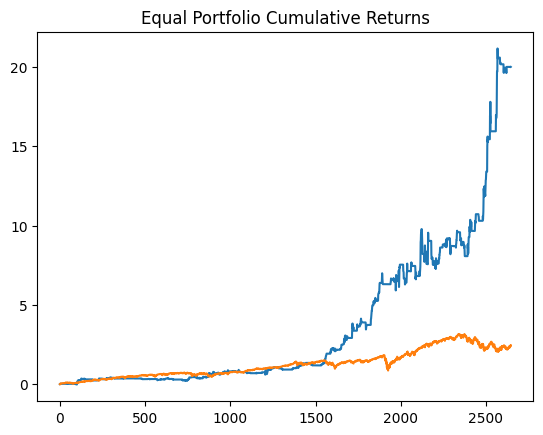

In [1181]:
ports_ff['cum_ret'].plot(title='Equal Portfolio Cumulative Returns')
ports_ff['mkt_cum_ret'].plot()

### Mean Variance Portfolio

In [1182]:
capm_eq=sm.OLS(ports_ff['portfolio_ret_mv'],
              sm.add_constant(ports_ff[['Mkt-RF']])).fit()
print(capm_eq.summary())

                            OLS Regression Results                            
Dep. Variable:       portfolio_ret_mv   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7.996
Date:                Mon, 02 Jun 2025   Prob (F-statistic):            0.00472
Time:                        23:48:29   Log-Likelihood:                -6586.8
No. Observations:                2647   AIC:                         1.318e+04
Df Residuals:                    2645   BIC:                         1.319e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1498      0.057     -2.640      0.0

In [1183]:
ff3_eq=sm.OLS(ports_ff['portfolio_ret_mv'],
              sm.add_constant(ports_ff[['Mkt-RF', 'SMB', 'HML']])).fit()
print(ff3_eq.summary())

                            OLS Regression Results                            
Dep. Variable:       portfolio_ret_mv   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4.796
Date:                Mon, 02 Jun 2025   Prob (F-statistic):            0.00246
Time:                        23:48:29   Log-Likelihood:                -6583.6
No. Observations:                2647   AIC:                         1.318e+04
Df Residuals:                    2643   BIC:                         1.320e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1482      0.057     -2.615      0.0

In [1184]:
ff5_eq=sm.OLS(ports_ff['portfolio_ret_mv'],
              sm.add_constant(ports_ff[['Mkt-RF', 'SMB', 'HML', 'CMA', 'RMW']])).fit()
print(ff5_eq.summary())

                            OLS Regression Results                            
Dep. Variable:       portfolio_ret_mv   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.500
Date:                Mon, 02 Jun 2025   Prob (F-statistic):            0.00371
Time:                        23:48:29   Log-Likelihood:                -6582.1
No. Observations:                2647   AIC:                         1.318e+04
Df Residuals:                    2641   BIC:                         1.321e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1442      0.057     -2.542      0.0

In [1185]:
ff6_eq=sm.OLS(ports_ff['portfolio_ret_mv'],
              sm.add_constant(ports_ff[['Mkt-RF', 'SMB', 'HML', 'CMA', 'RMW', 'MOM']])).fit()
print(ff6_eq.summary())

                            OLS Regression Results                            
Dep. Variable:       portfolio_ret_mv   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.265
Date:                Mon, 02 Jun 2025   Prob (F-statistic):            0.00335
Time:                        23:48:29   Log-Likelihood:                -6581.0
No. Observations:                2647   AIC:                         1.318e+04
Df Residuals:                    2640   BIC:                         1.322e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1440      0.057     -2.540      0.0

In [1186]:
ports_ff['cum_ret_mv'] = (1 + (ports_ff['portfolio_ret_mv'] / 100)).cumprod() - 1
ports_ff['mkt_cum_ret'] = (1 + (ports_ff['Mkt-RF'] / 100)).cumprod() - 1

<Axes: title={'center': 'Mean Variance Portfolio Cumulative Returns'}>

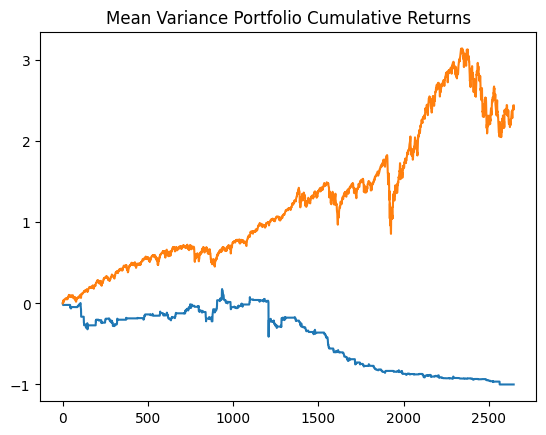

In [1187]:
ports_ff['cum_ret_mv'].plot(title='Mean Variance Portfolio Cumulative Returns')
ports_ff['mkt_cum_ret'].plot()

### Risk Parity Portfolio

In [1188]:
capm_eq=sm.OLS(ports_ff['portfolio_ret_rp'],
              sm.add_constant(ports_ff[['Mkt-RF']])).fit()
print(capm_eq.summary())

                            OLS Regression Results                            
Dep. Variable:       portfolio_ret_rp   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     33.81
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           6.80e-09
Time:                        23:48:29   Log-Likelihood:                -4806.9
No. Observations:                2647   AIC:                             9618.
Df Residuals:                    2645   BIC:                             9630.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1295      0.029     -4.472      0.0

In [1189]:
ff3_eq=sm.OLS(ports_ff['portfolio_ret_rp'],
              sm.add_constant(ports_ff[['Mkt-RF', 'SMB', 'HML']])).fit()
print(ff3_eq.summary())

                            OLS Regression Results                            
Dep. Variable:       portfolio_ret_rp   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     14.39
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           2.69e-09
Time:                        23:48:30   Log-Likelihood:                -4802.3
No. Observations:                2647   AIC:                             9613.
Df Residuals:                    2643   BIC:                             9636.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1287      0.029     -4.450      0.0

In [1190]:
ff5_eq=sm.OLS(ports_ff['portfolio_ret_rp'],
              sm.add_constant(ports_ff[['Mkt-RF', 'SMB', 'HML', 'CMA', 'RMW']])).fit()
print(ff5_eq.summary())

                            OLS Regression Results                            
Dep. Variable:       portfolio_ret_rp   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     8.921
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           2.05e-08
Time:                        23:48:30   Log-Likelihood:                -4801.6
No. Observations:                2647   AIC:                             9615.
Df Residuals:                    2641   BIC:                             9650.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1274      0.029     -4.402      0.0

In [1191]:
ff6_eq=sm.OLS(ports_ff['portfolio_ret_rp'],
              sm.add_constant(ports_ff[['Mkt-RF', 'SMB', 'HML', 'CMA', 'RMW', 'MOM']])).fit()
print(ff6_eq.summary())

                            OLS Regression Results                            
Dep. Variable:       portfolio_ret_rp   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     8.039
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           1.27e-08
Time:                        23:48:30   Log-Likelihood:                -4799.8
No. Observations:                2647   AIC:                             9614.
Df Residuals:                    2640   BIC:                             9655.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1273      0.029     -4.401      0.0

In [1192]:
ports_ff['cum_ret_rp'] = (1 + (ports_ff['portfolio_ret_rp'] / 100)).cumprod() - 1
ports_ff['mkt_cum_ret'] = (1 + (ports_ff['Mkt-RF'] / 100)).cumprod() - 1

<Axes: title={'center': 'Risk Parity Portfolio Cumulative Returns'}>

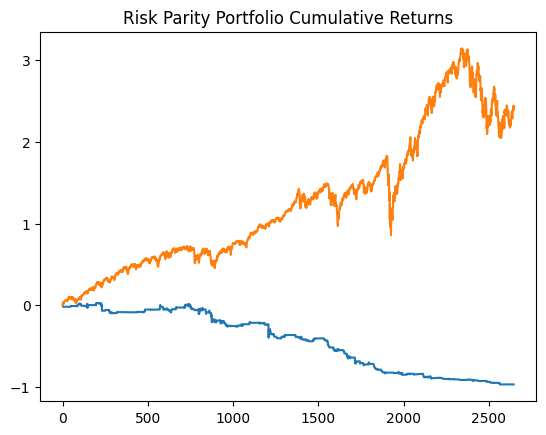

In [1193]:
ports_ff['cum_ret_rp'].plot(title='Risk Parity Portfolio Cumulative Returns')
ports_ff['mkt_cum_ret'].plot()